# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- Countries
    - [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
    - [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
    - [Time-series plots of infections in most infected countries](#time-series_countries)
    - [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
    - [Relative increases per day by country](#country_relative_increases)
    - [Time-series plots of mortality](#time-series_country_mortality)
    - [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
      - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
    - [Density of infections per million people](#density_of_infections_by_country)
    - [How many days behind is each country from Italy?](#days_behind)
- US states
    - [US states with the most new infections](#states_most_infections)
    - [Time-series plots of infections in most-infected states](#time-series_states)
    - [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
    - [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
    - [Compare US state infections against Washington](#state_infections_vs_wa)
    - [Compare US state infections against New York](#state_infections_vs_ny)
    - [Mortality rate by US state](#mortality_by_us_state)
    - [Relative increases per day by state](#us_state_relative_increases)
    - [When will each US state hit 1 case?](#us_state_0_new)
    - [Smoothed trend for each US state](#us_state_smoothed_trend)

In [2]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [1]:
#plt.style.available

In [3]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [484]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [485]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [486]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-07-07 23:46:47.575775
metric: deaths at 2020-07-07 23:46:50.743730
Latest data from 2020-07-07


In [487]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [488]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-07-07              US    2996098          60021  131480        1195   
1  2020-07-07          Brazil    1668589          45305   66741        1254   
2  2020-07-07  United Kingdom     287874            584   44476         155   
3  2020-07-07           Italy     241956            137   34899          30   
4  2020-07-07          Mexico     268008           6258   32014         895   
5  2020-07-07          France     206072            475   29936          13   
6  2020-07-07           Spain     252130            341   28392           4   
7  2020-07-07           India     742417          22753   20642         483   
8  2020-07-07            Iran     245688           2637   11931         200   
9  2020-07-07            Peru     309278           3575   10952         180   
10 2020-07-07          Russia     693215           6363   10478         198   
11 2020-07-07         Belgium      62058              0    9774           0   
12 2020-07-07         Germany     198343            279    9032          10   
13 2020-07-07          Canada     108023            208    8765          17   
14 2020-07-07           Chile     301019           2462    6434          50   
15 2020-07-07     Netherlands      50907             37    6151           4   
16 2020-07-07          Sweden      73344            283    5447          14   
17 2020-07-07          Turkey     207897           1053    5260          19   
18 2020-07-07        Pakistan     237489           2980    4922          83   
19 2020-07-07         Ecuador      63245            865    4873          52   

    mortality_rate  
0         0.043884  
1         0.039998  
2         0.154498  
3         0.144237  
4         0.119452  
5         0.145270  
6         0.112609  
7         0.027804  
8         0.048562  
9         0.035412  
10        0.015115  
11        0.157498  
12        0.045537  
13        0.081140  
14        0.021374  
15        0.120828  
16        0.074266  
17        0.025301  
18        0.020725  
19        0.077050

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [489]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-07-07            US    2996098          60021  131480        1195   
1  2020-07-07        Brazil    1668589          45305   66741        1254   
7  2020-07-07         India     742417          22753   20642         483   
22 2020-07-07  South Africa     215855          10134    3502         192   
10 2020-07-07        Russia     693215           6363   10478         198   
4  2020-07-07        Mexico     268008           6258   32014         895   
9  2020-07-07          Peru     309278           3575   10952         180   
27 2020-07-07  Saudi Arabia     217108           3392    2017          49   
26 2020-07-07    Bangladesh     168645           3027    2151          55   
18 2020-07-07      Pakistan     237489           2980    4922          83   

    mortality_rate  
0         0.043884  
1         0.039998  
7         0.027804  
22        0.016224  
10        0.015115  
4         0.119452  
9         0.035412  
27        0.009290  
26        0.012755  
18        0.020725

In [490]:
dfp_top_countries.sort_values(by='deaths_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
1  2020-07-07          Brazil    1668589          45305   66741        1254   
0  2020-07-07              US    2996098          60021  131480        1195   
4  2020-07-07          Mexico     268008           6258   32014         895   
7  2020-07-07           India     742417          22753   20642         483   
8  2020-07-07            Iran     245688           2637   11931         200   
10 2020-07-07          Russia     693215           6363   10478         198   
22 2020-07-07    South Africa     215855          10134    3502         192   
9  2020-07-07            Peru     309278           3575   10952         180   
2  2020-07-07  United Kingdom     287874            584   44476         155   
21 2020-07-07        Colombia     120281           2869    4452         147   

    mortality_rate  
1         0.039998  
0         0.043884  
4         0.119452  
7         0.027804  
8         0.048562  
10        0.015115  
22        0.016224  
9         0.035412  
2         0.154498  
21        0.037013

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [491]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

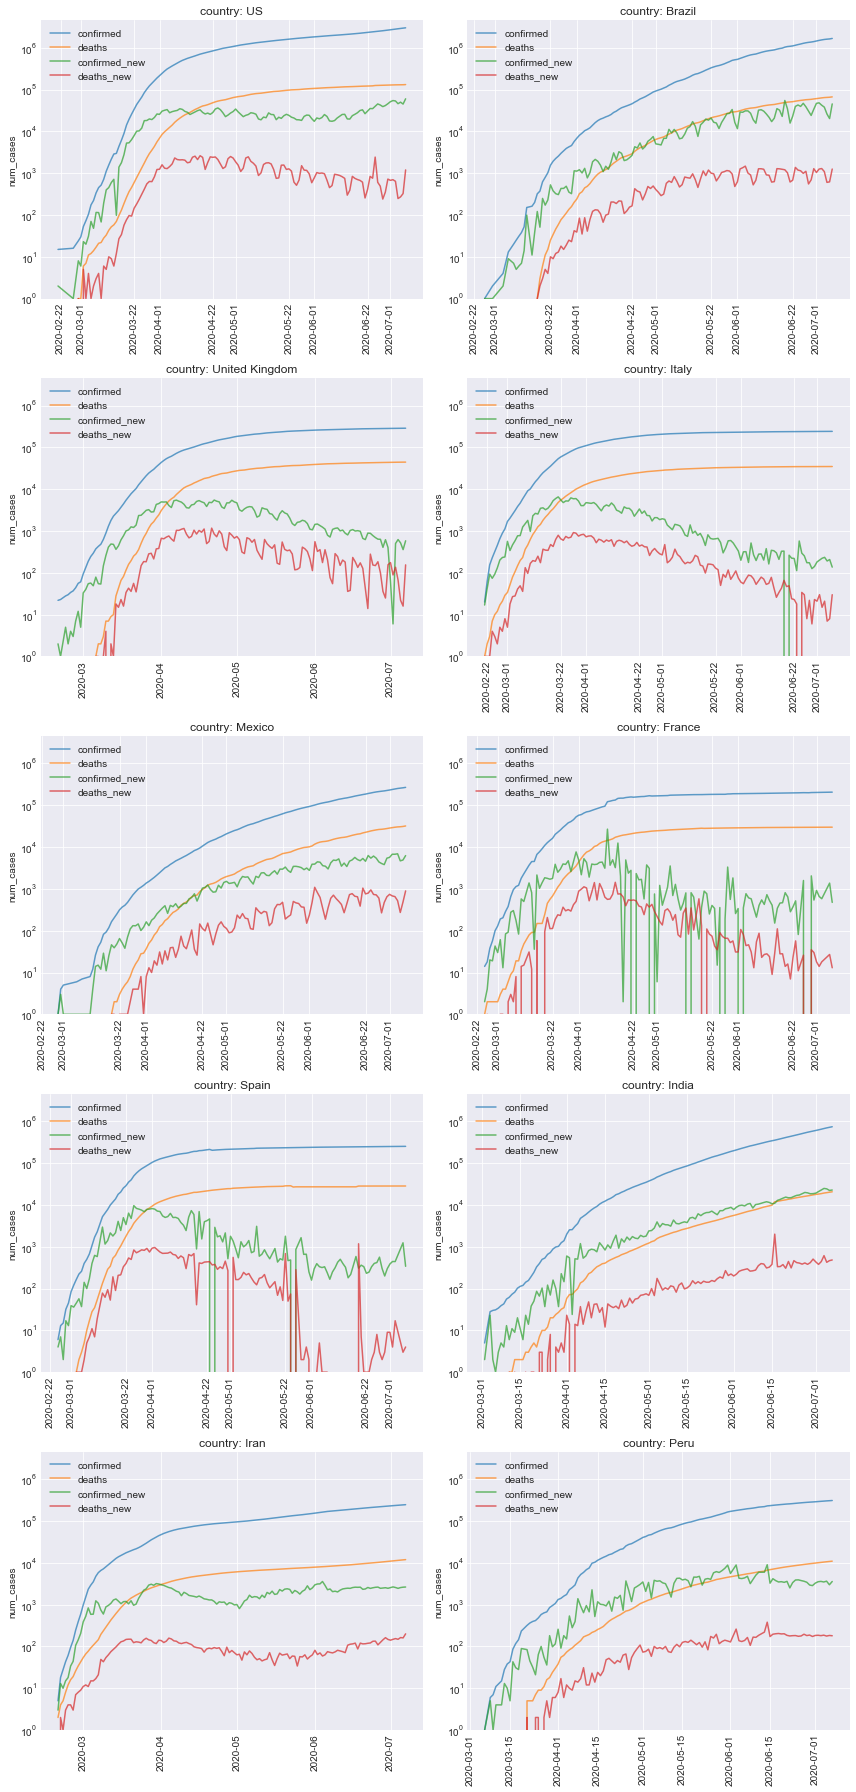

In [492]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

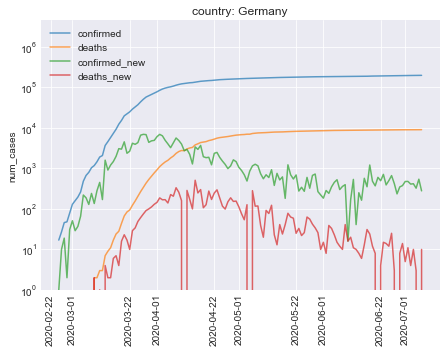

In [493]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [494]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1, cols_to_be_null_in_future=[]):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    cols_nullable = ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']
    cols_nullable.extend(cols_to_be_null_in_future)
    for col in cols_nullable:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-07-08 2020-07-14 2020-07-28  2020-07-08 2020-07-14   
country                                                                      
US                  3048263.0  3390400.0  4345578.0    131634.0   134626.0   
Brazil              1710094.0  1955890.0  2675681.0     67855.0    74366.0   
United Kingdom       288260.0   291064.0   297712.0     44529.0    44968.0   
Italy                242206.0   243442.0   246349.0     34912.0    35011.0   
Mexico               275392.0   317771.0   443774.0     32467.0    36156.0   
France               206311.0   209181.0   216033.0     29942.0    30007.0   
Spain                252302.0   254637.0   260169.0     28398.0    28425.0   
India                771113.0   949098.0  1540850.0     21190.0    24597.0   
Iran                 248365.0   264963.0   308135.0     12076.0    13134.0   
Peru                 313075.0   335611.0   394704.0     11155.0    12389.0   

                          mortality_rate_pred                        \
date           2020-07-28          2020-07-08 2020-07-14 2020-07-28   
country                                                               
US               141875.0            0.043183   0.039708   0.032648   
Brazil            92094.0            0.039679   0.038022   0.034419   
United Kingdom    46010.0            0.154475   0.154495   0.154545   
Italy             35245.0            0.144142   0.143817   0.143069   
Mexico            46474.0            0.117894   0.113780   0.104724   
France            30161.0            0.145130   0.143450   0.139613   
Spain             28487.0            0.112556   0.111629   0.109494   
India             34833.0            0.027480   0.025916   0.022606   
Iran              15978.0            0.048622   0.049569   0.051854   
Peru              15827.0            0.035630   0.036915   0.040098   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.017887             0.003753  
Brazil                        0.022635             0.015389  
United Kingdom                0.001614             0.001637  
Italy                         0.000848             0.000475  
Mexico                        0.024143             0.018095  
France                        0.002305             0.000366  
Spain                         0.001536             0.000156  
India                         0.035219             0.025163  
Iran                          0.010840             0.014097  
Peru                          0.011652             0.017645

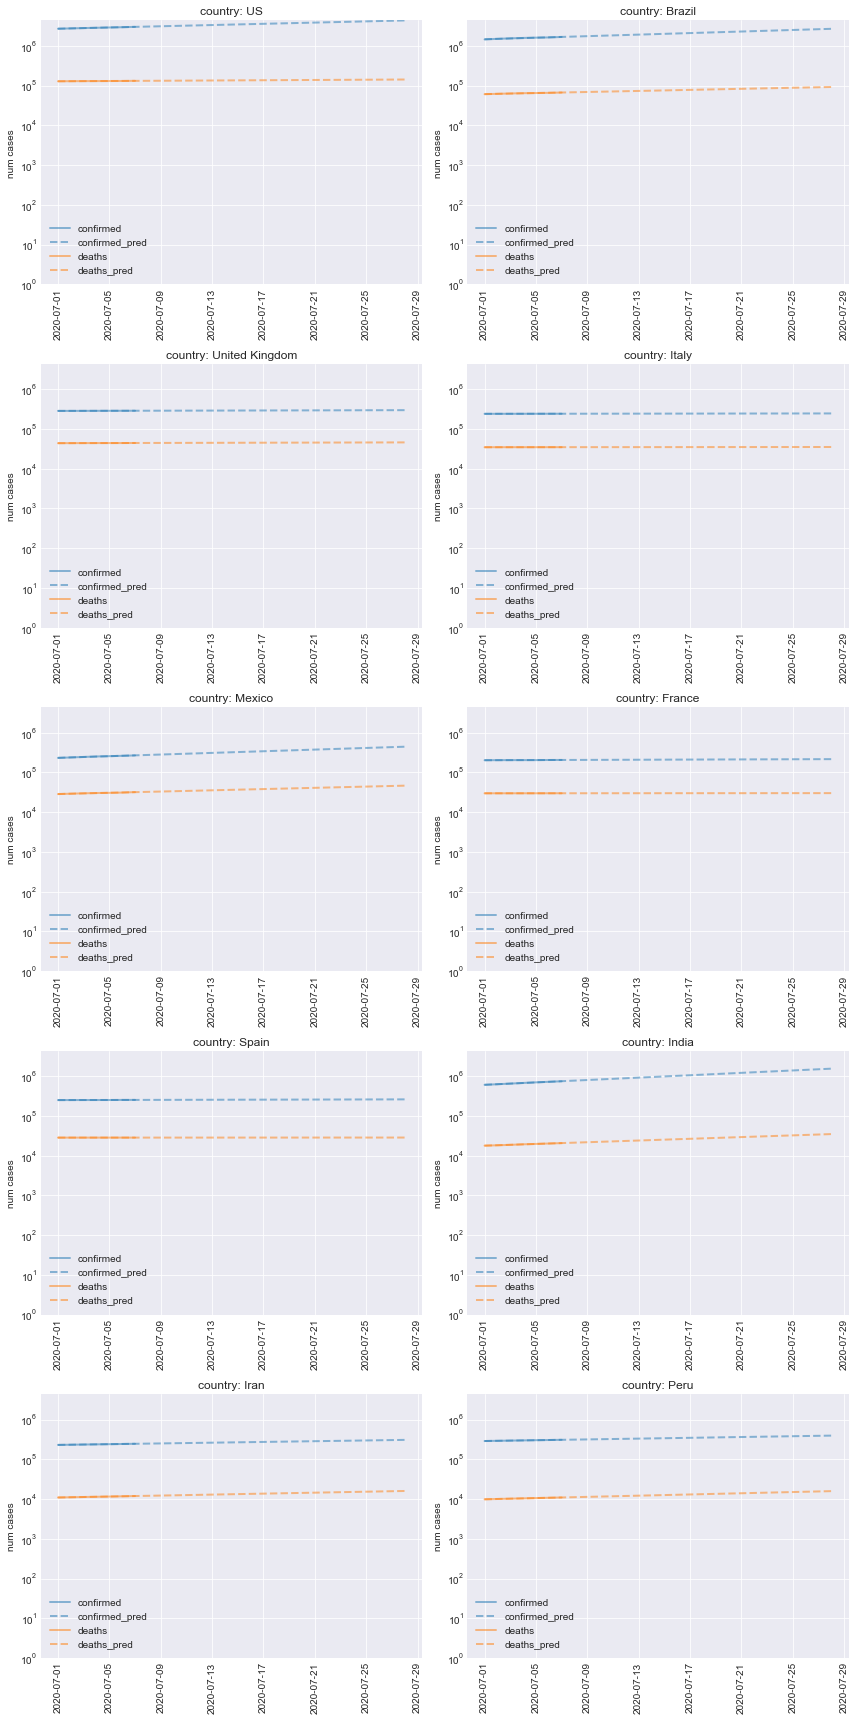

In [495]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [496]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-07-07_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [497]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


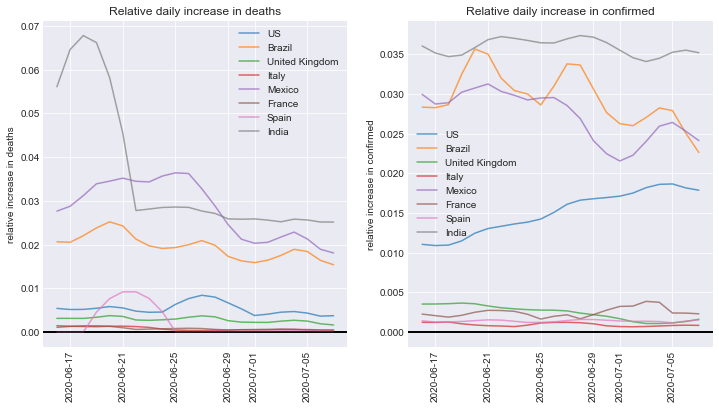

In [498]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-07-08 2020-07-14  2020-07-08 2020-07-14   
country                                                           
US                  3046132.0  3386763.0    132026.0   135621.0   
Brazil              1732360.0  2023956.0     68140.0    75259.0   
United Kingdom       288222.0   290811.0     44621.0    45222.0   
Italy                242157.0   243304.0     34919.0    35032.0   
Mexico               274963.0   316854.0     32759.0    37036.0   
France               206734.0   210398.0     29958.0    30052.0   
Spain                252230.0   254423.0     28401.0    28434.0   
India                771740.0   950090.0     21217.0    24677.0   
Iran                 248695.0   265837.0     12055.0    13076.0   
Peru                 313400.0   336327.0     11212.0    12546.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-07-08 2020-07-14                           
country                                                                 
US                        0.043342   0.040044                0.017824   
Brazil                    0.039334   0.037184                0.026267   
United Kingdom            0.154815   0.155503                0.001491   
Italy                     0.144200   0.143984                0.000788   
Mexico                    0.119140   0.116887                0.023916   
France                    0.144911   0.142834                0.002932   
Spain                     0.112600   0.111759                0.001444   
India                     0.027492   0.025973                0.035259   
Iran                      0.048473   0.049188                0.011172   
Peru                      0.035775   0.037303                0.011837   

               frac_increase_deaths  
date                                 
country                              
US                         0.004487  
Brazil                     0.016701  
United Kingdom             0.002234  
Italy                      0.000536  
Mexico                     0.020662  
France                     0.000523  
Spain                      0.000194  
India                      0.025496  
Iran                       0.013643  
Peru                       0.018919

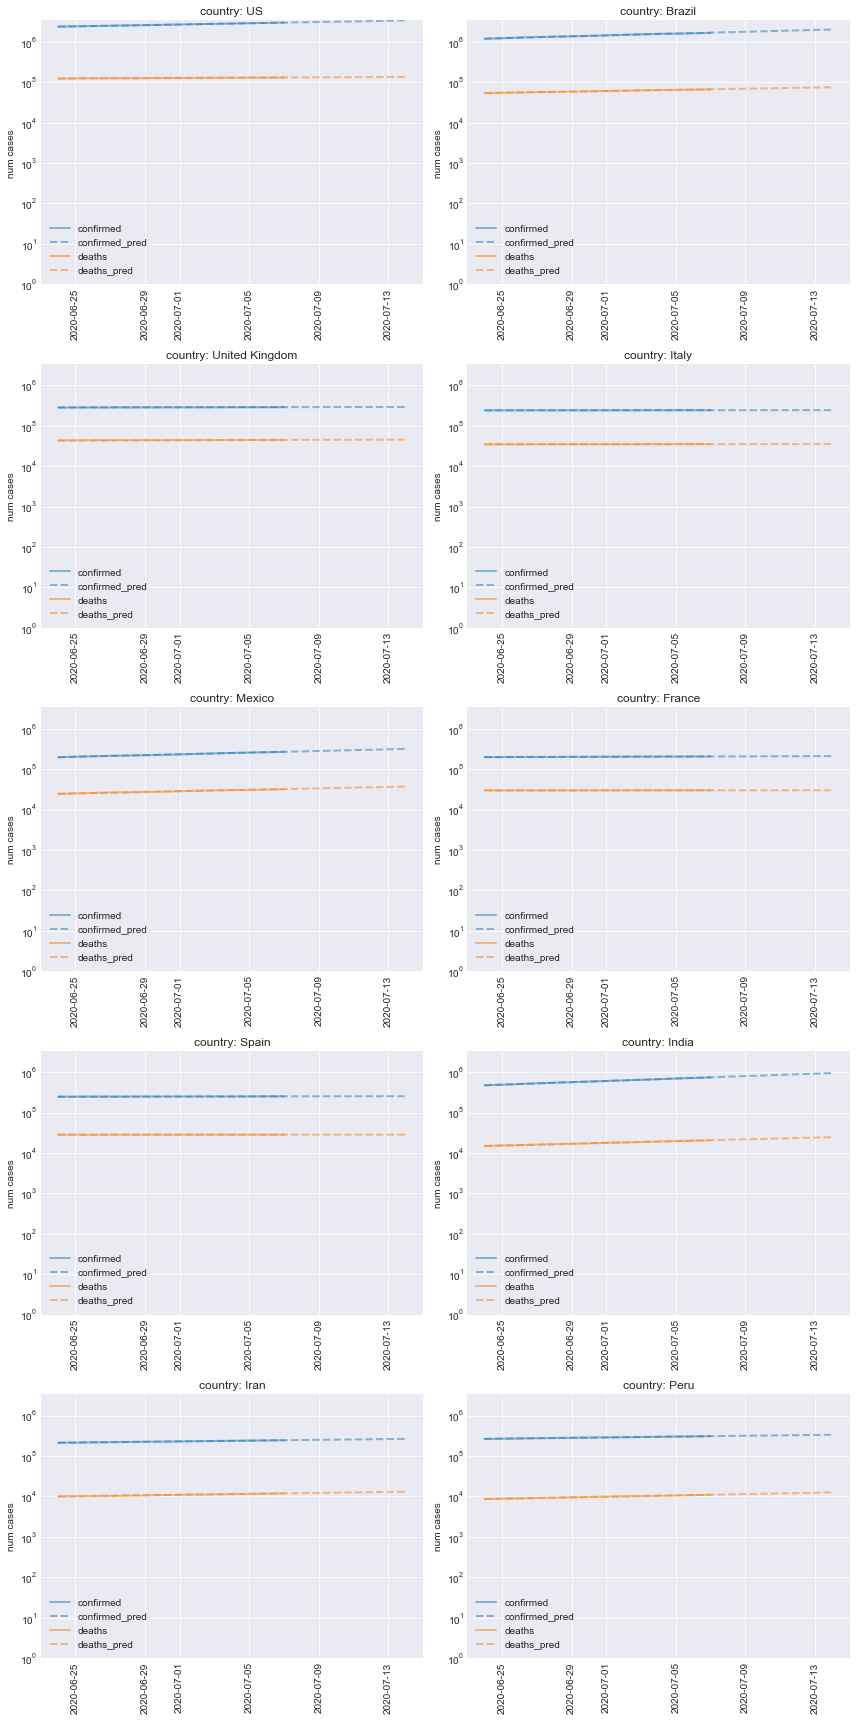

In [499]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [500]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-07-07_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [501]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

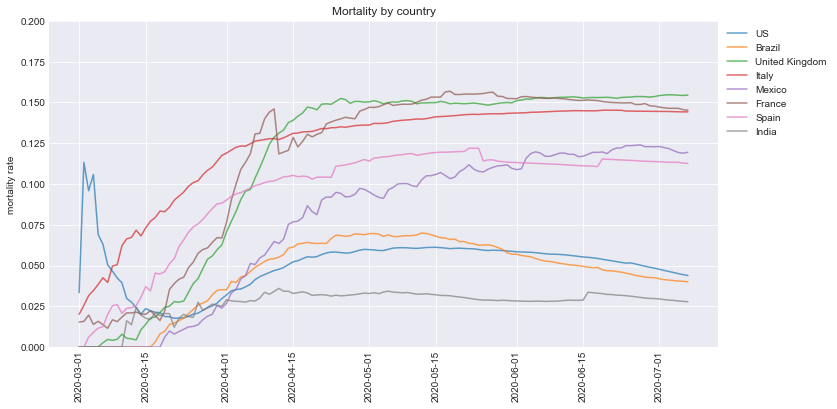

In [502]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [503]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

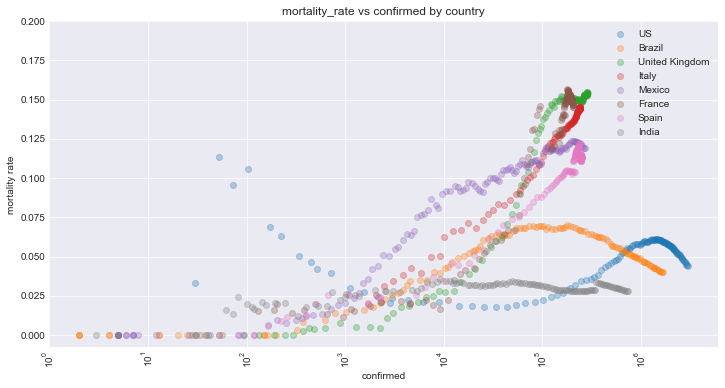

In [504]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [505]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

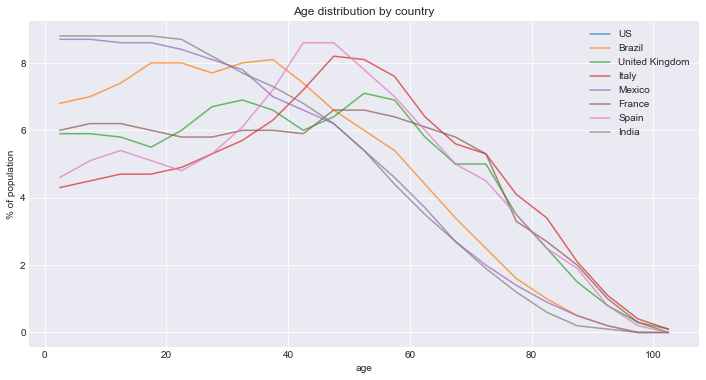

In [506]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

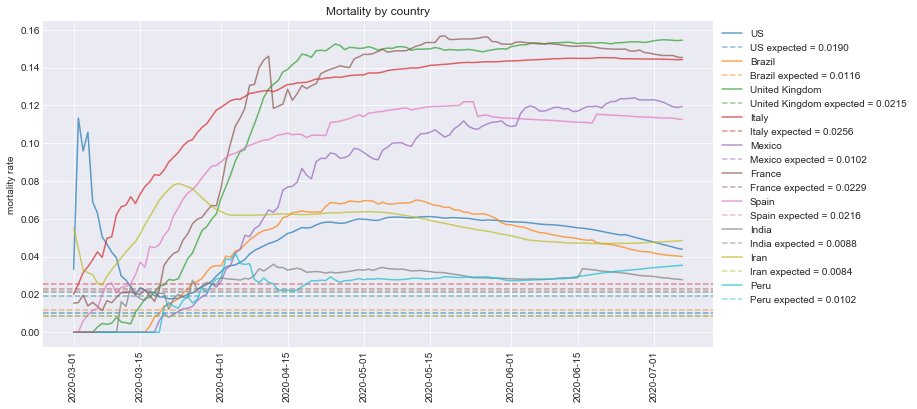

date         country  mortality_rate  confirmed    deaths
0 2020-07-07  United Kingdom        0.154498   287874.0   44476.0
1 2020-07-07          France        0.145270   206072.0   29936.0
2 2020-07-07           Italy        0.144237   241956.0   34899.0
3 2020-07-07          Mexico        0.119452   268008.0   32014.0
4 2020-07-07           Spain        0.112609   252130.0   28392.0
5 2020-07-07            Iran        0.048562   245688.0   11931.0
6 2020-07-07              US        0.043884  2996098.0  131480.0
7 2020-07-07          Brazil        0.039998  1668589.0   66741.0
8 2020-07-07            Peru        0.035412   309278.0   10952.0
9 2020-07-07           India        0.027804   742417.0   20642.0

In [507]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

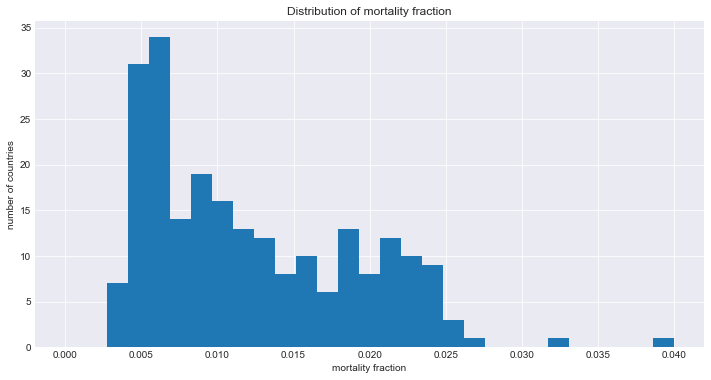

In [508]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [509]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [510]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

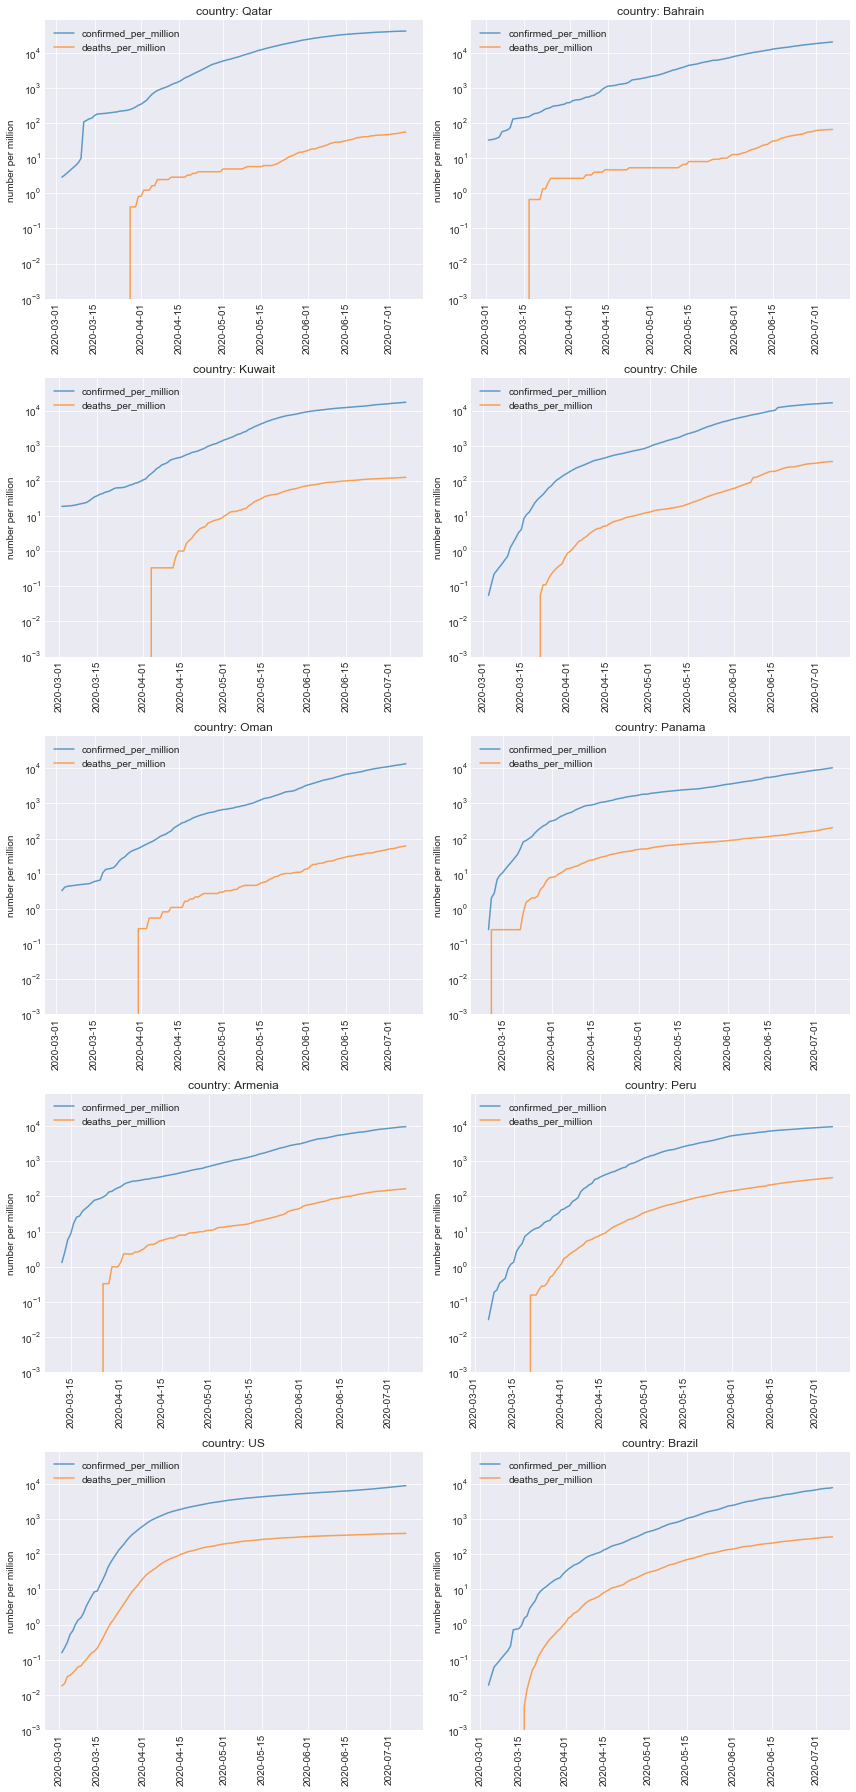

country   population  confirmed    deaths  confirmed_per_million  \
0    Qatar    2444174.0   100945.0     134.0           41300.251128   
1  Bahrain    1505003.0    30321.0      98.0           20146.803694   
2   Kuwait    2993706.0    51245.0     377.0           17117.579348   
3    Chile   18186770.0   301019.0    6434.0           16551.537189   
4     Oman    3634689.0    48997.0     224.0           13480.383053   
5   Panama    3894082.0    40291.0     799.0           10346.726135   
6  Armenia    3021324.0    29285.0     503.0            9692.770454   
7     Peru   31914989.0   309278.0   10952.0            9690.681704   
8       US  332639102.0  2996098.0  131480.0            9007.052935   
9   Brazil  211715973.0  1668589.0   66741.0            7881.261751   

   deaths_per_million  mortality_rate  
0           54.824247        0.001327  
1           65.116149        0.003232  
2          125.930870        0.007357  
3          353.773650        0.021374  
4           61.628381        0.004572  
5          205.183147        0.019831  
6          166.483303        0.017176  
7          343.161641        0.035412  
8          395.263212        0.043884  
9          315.238378        0.039998

In [511]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [512]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed    deaths  confirmed_per_million  \
18         Belgium   11720716.0    62058.0    9774.0            5294.727728   
24  United Kingdom   65761117.0   287874.0   44476.0            4377.571628   
21           Spain   50015792.0   252130.0   28392.0            5041.007848   
26           Italy   62402659.0   241956.0   34899.0            3877.334778   
12          Sweden   10202491.0    73344.0    5447.0            7188.832610   
36          France   67848156.0   206072.0   29936.0            3037.252774   
8               US  332639102.0  2996098.0  131480.0            9007.052935   
37     Netherlands   17280397.0    50907.0    6151.0            2945.939263   
3            Chile   18186770.0   301019.0    6434.0           16551.537189   
7             Peru   31914989.0   309278.0   10952.0            9690.681704   

    deaths_per_million  mortality_rate  
18          833.908099        0.157498  
24          676.326711        0.154498  
21          567.660710        0.112609  
26          559.255015        0.144237  
12          533.889224        0.074266  
36          441.220540        0.145270  
8           395.263212        0.043884  
37          355.952470        0.120828  
3           353.773650        0.021374  
7           343.161641        0.035412

### Mortality rate by deaths per capita, confirmed per capita

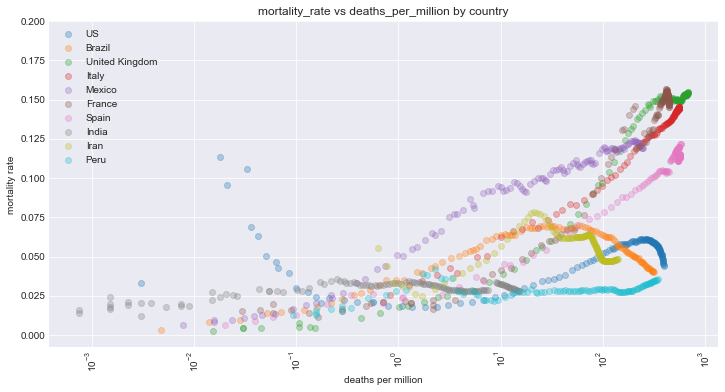

In [513]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

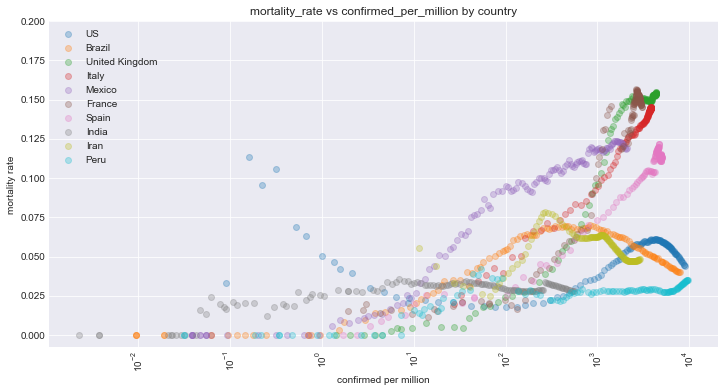

In [514]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [515]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

In [516]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

In [517]:
# _ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [518]:
# # load and clean data
# dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
# dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
#                                         'positive': 'confirmed',
#                                         'death': 'deaths',
#                                         'date': 'date_str'
#                                        })
# dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
# dfp_us_raw['country'] = 'US'

In [519]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered', 'people_hospitalized']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update',
                      'People_Hospitalized': 'people_hospitalized'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    #dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    
    dfp_temp['date'] = datetime.datetime.strptime(path.split('.')[0], '%m-%d-%Y')
    #dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [520]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')
# dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
# dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# # aggregate infections by state
# dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
#             agg({
#                 'confirmed': np.sum,
#                 'deaths': np.sum,
#                 #'recovered': np.sum,
#                })
#            )
# dfp_us_g.shape

In [521]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

In [522]:
dfp_us_g.shape

(5064, 10)

In [523]:
dfp_us_g[dfp_us_g.state == 'Iowa'].tail()

date country state  confirmed  deaths  confirmed_lag1  deaths_lag1  \
4793 2020-07-03      US  Iowa      30463     721         30259.0        719.0   
4851 2020-07-04      US  Iowa      31061     721         30463.0        721.0   
4909 2020-07-05      US  Iowa      31517     721         31061.0        721.0   
4967 2020-07-06      US  Iowa      31758     723         31517.0        721.0   
5025 2020-07-07      US  Iowa      32153     732         31758.0        723.0   

      confirmed_new  deaths_new  mortality_rate  
4793          204.0         2.0        0.023668  
4851          598.0         0.0        0.023212  
4909          456.0         0.0        0.022877  
4967          241.0         2.0        0.022766  
5025          395.0         9.0        0.022766

<a id='states_most_infections'></a>
### US states with the most new infections

In [524]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-07-07       New York     398237            588   32243          24   
1  2020-07-07     New Jersey     173878            267   15281          52   
2  2020-07-07  Massachusetts     110338            201    8213          15   
3  2020-07-07       Illinois     149574           1709    7273         247   
4  2020-07-07   Pennsylvania      95898            798    6787          33   
5  2020-07-07     California     284012          12977    6573         132   
6  2020-07-07       Michigan      73900            633    6251          30   
7  2020-07-07    Connecticut      47033             57    4338           0   
8  2020-07-07        Florida     213794           7347    3841          63   
9  2020-07-07      Louisiana      68263           1936    3319          23   
10 2020-07-07       Maryland      70396            492    3266          20   
11 2020-07-07           Ohio      58904            948    2970          43   
12 2020-07-07        Georgia     100470           3406    2899          21   
13 2020-07-07          Texas     216026          10384    2778         101   
14 2020-07-07        Indiana      48626            102    2717          19   

    mortality_rate  
0         0.080964  
1         0.087883  
2         0.074435  
3         0.048625  
4         0.070773  
5         0.023143  
6         0.084587  
7         0.092233  
8         0.017966  
9         0.048621  
10        0.046395  
11        0.050421  
12        0.028854  
13        0.012860  
14        0.055875

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [525]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

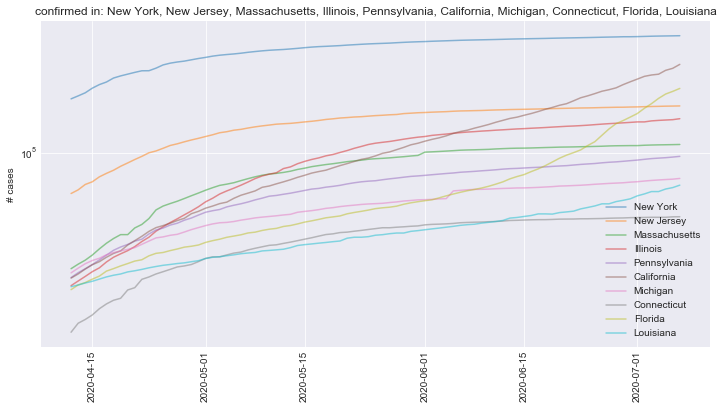

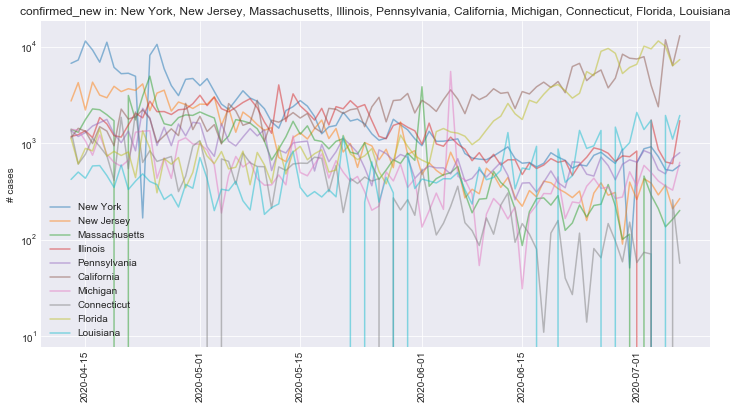

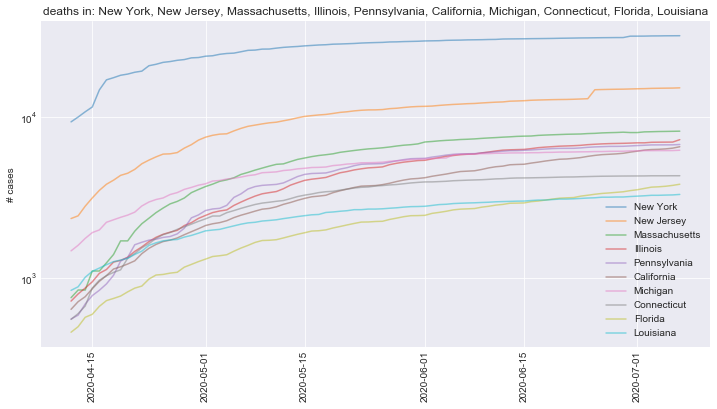

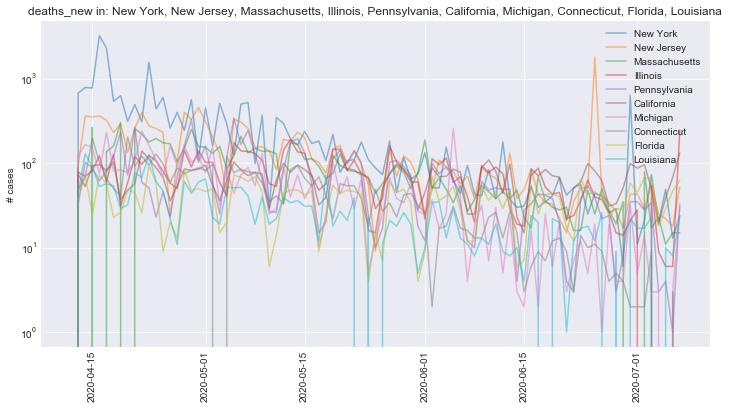

In [526]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

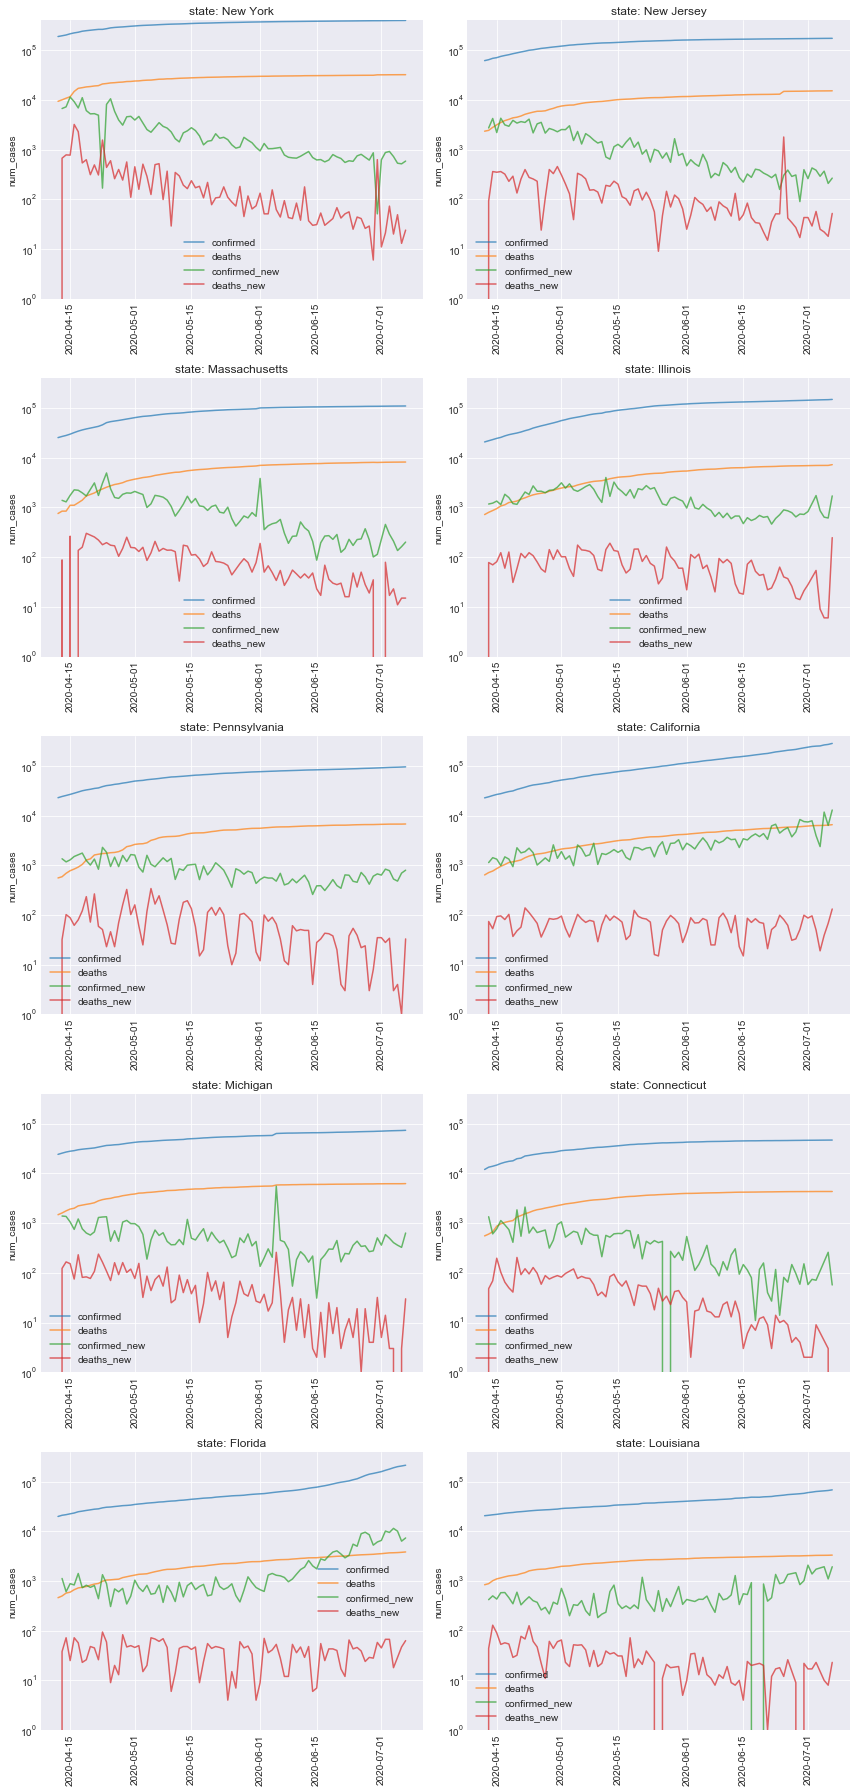

In [527]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

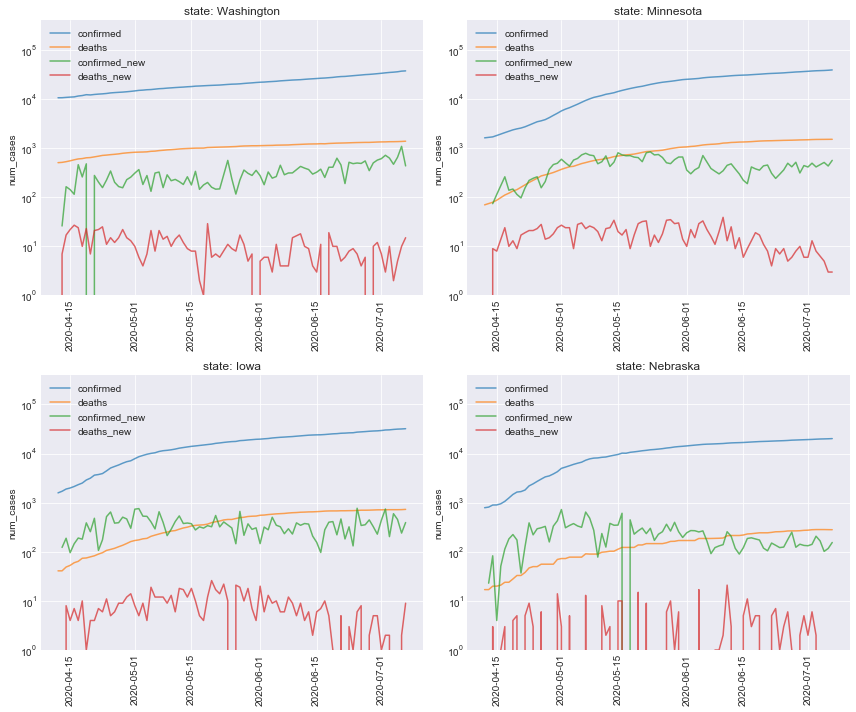

In [528]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-07-08 2020-07-14 2020-07-28  2020-07-08 2020-07-14   
state                                                                       
New York            399099.0   403248.0   413098.0     32292.0    32504.0   
New Jersey          174285.0   176244.0   180901.0     15308.0    15504.0   
Massachusetts       110638.0   112011.0   115282.0      8249.0     8391.0   
Illinois            150170.0   155966.0   170372.0      7195.0     7445.0   
Pennsylvania         96522.0   100654.0   110997.0      6798.0     6885.0   
California          287765.0   339100.0   497361.0      6587.0     6956.0   
Michigan             74303.0    77072.0    83942.0      6244.0     6283.0   
Connecticut          47060.0    47502.0    48550.0      4342.0     4356.0   
Florida             228701.0   308792.0   622197.0      3881.0     4171.0   
Louisiana            69269.0    78058.0   103151.0      3326.0     3400.0   

                         mortality_rate_pred                        \
date          2020-07-28          2020-07-08 2020-07-14 2020-07-28   
state                                                                
New York         33003.0            0.080912   0.080605   0.079891   
New Jersey       15971.0            0.087833   0.087969   0.088286   
Massachusetts     8731.0            0.074558   0.074912   0.075736   
Illinois          8063.0            0.047912   0.047735   0.047326   
Pennsylvania      7092.0            0.070430   0.068403   0.063894   
California        7902.0            0.022890   0.020513   0.015888   
Michigan          6375.0            0.084034   0.081521   0.075945   
Connecticut       4389.0            0.092265   0.091701   0.090402   
Florida           4934.0            0.016970   0.013507   0.007930   
Louisiana         3578.0            0.048016   0.043557   0.034687   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.001725             0.001088  
New Jersey                   0.001865             0.002120  
Massachusetts                0.002058             0.002838  
Illinois                     0.006331             0.005711  
Pennsylvania                 0.007011             0.002123  
California                   0.027736             0.009143  
Michigan                     0.006117             0.001033  
Connecticut                  0.001560             0.000544  
Florida                      0.051315             0.012077  
Louisiana                    0.020109             0.003657

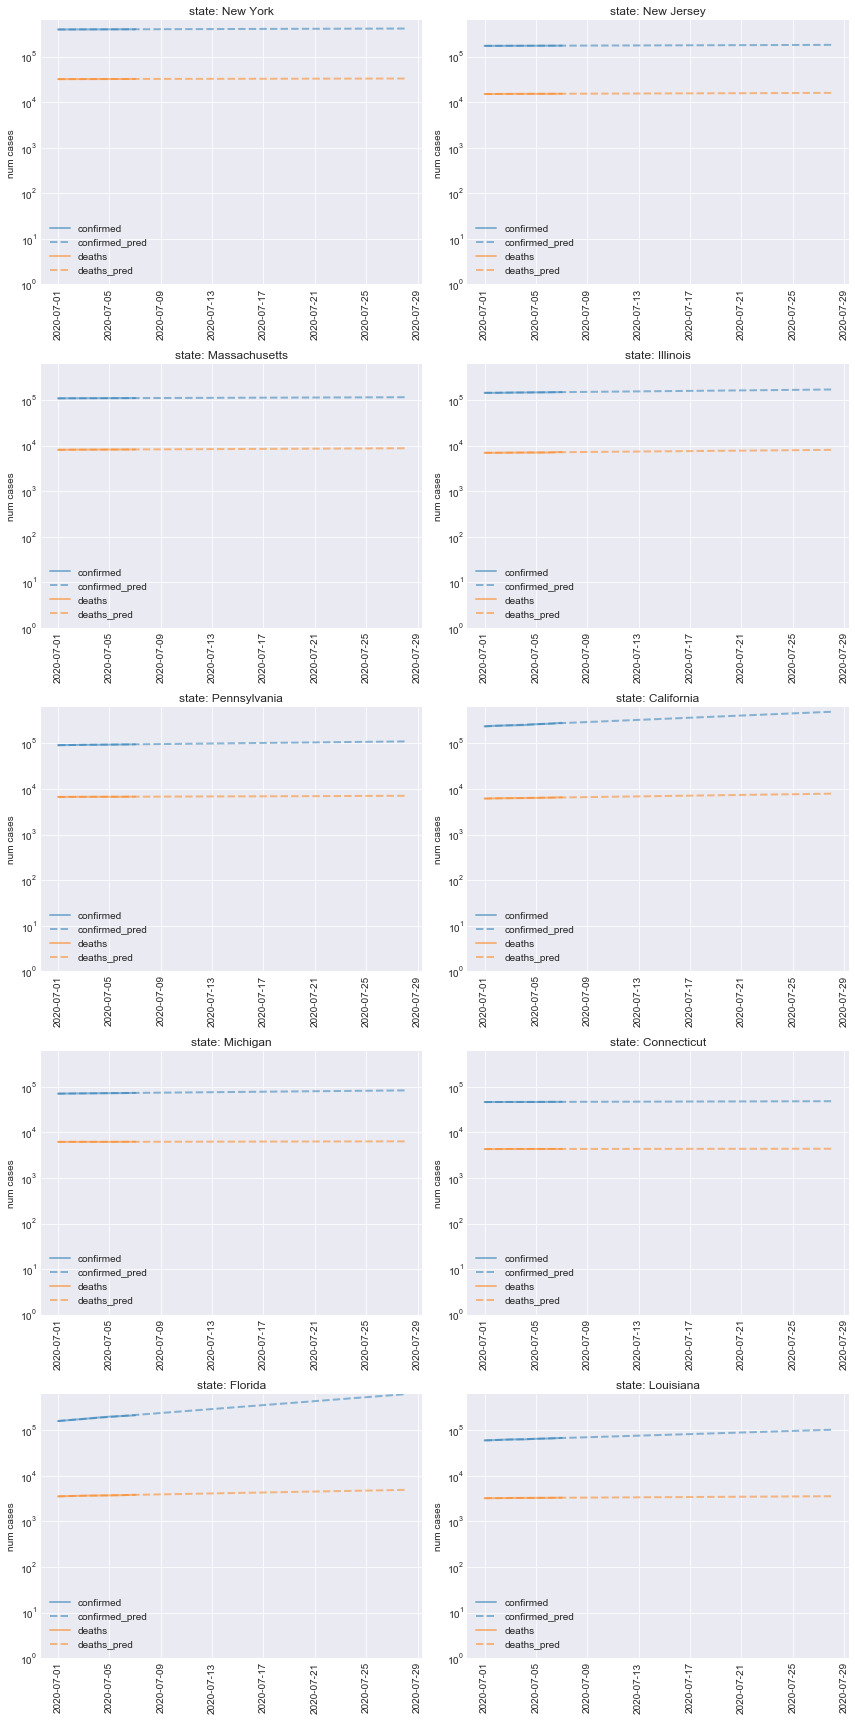

In [529]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-07-08 2020-07-14 2020-07-28  2020-07-08 2020-07-14   
state                                                                       
New York            399029.0   403040.0   412557.0     32494.0    33064.0   
New Jersey          174239.0   176136.0   180643.0     15593.0    16151.0   
Massachusetts       110589.0   111856.0   114869.0      8242.0     8367.0   
Illinois            149769.0   154841.0   167354.0      7149.0     7316.0   
Pennsylvania         96476.0   100576.0   110833.0      6819.0     6945.0   
California          288107.0   340594.0   503304.0      6607.0     7024.0   
Michigan             74174.0    76765.0    83169.0      6257.0     6316.0   
Connecticut          47107.0    47616.0    48824.0      4347.0     4369.0   
Florida             231391.0   316898.0   660069.0      3878.0     4171.0   
Louisiana            69215.0    78182.0   103885.0      3328.0     3406.0   

                         mortality_rate_pred                        \
date          2020-07-28          2020-07-08 2020-07-14 2020-07-28   
state                                                                
New York         34435.0            0.081433   0.082037   0.083467   
New Jersey       17531.0            0.089492   0.091696   0.097048   
Massachusetts     8666.0            0.074528   0.074802   0.075442   
Illinois          7721.0            0.047734   0.047248   0.046136   
Pennsylvania      7250.0            0.070681   0.069052   0.065414   
California        8103.0            0.022932   0.020623   0.016100   
Michigan          6456.0            0.084356   0.082277   0.077625   
Connecticut       4421.0            0.092279   0.091755   0.090550   
Florida           4943.0            0.016760   0.013162   0.007489   
Louisiana         3596.0            0.048082   0.043565   0.034615   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.001668             0.002905  
New Jersey                   0.001806             0.005874  
Massachusetts                0.001900             0.002507  
Illinois                     0.005566             0.003857  
Pennsylvania                 0.006961             0.003068  
California                   0.028286             0.010258  
Michigan                     0.005739             0.001569  
Connecticut                  0.001792             0.000834  
Florida                      0.053809             0.012206  
Louisiana                    0.020510             0.003882

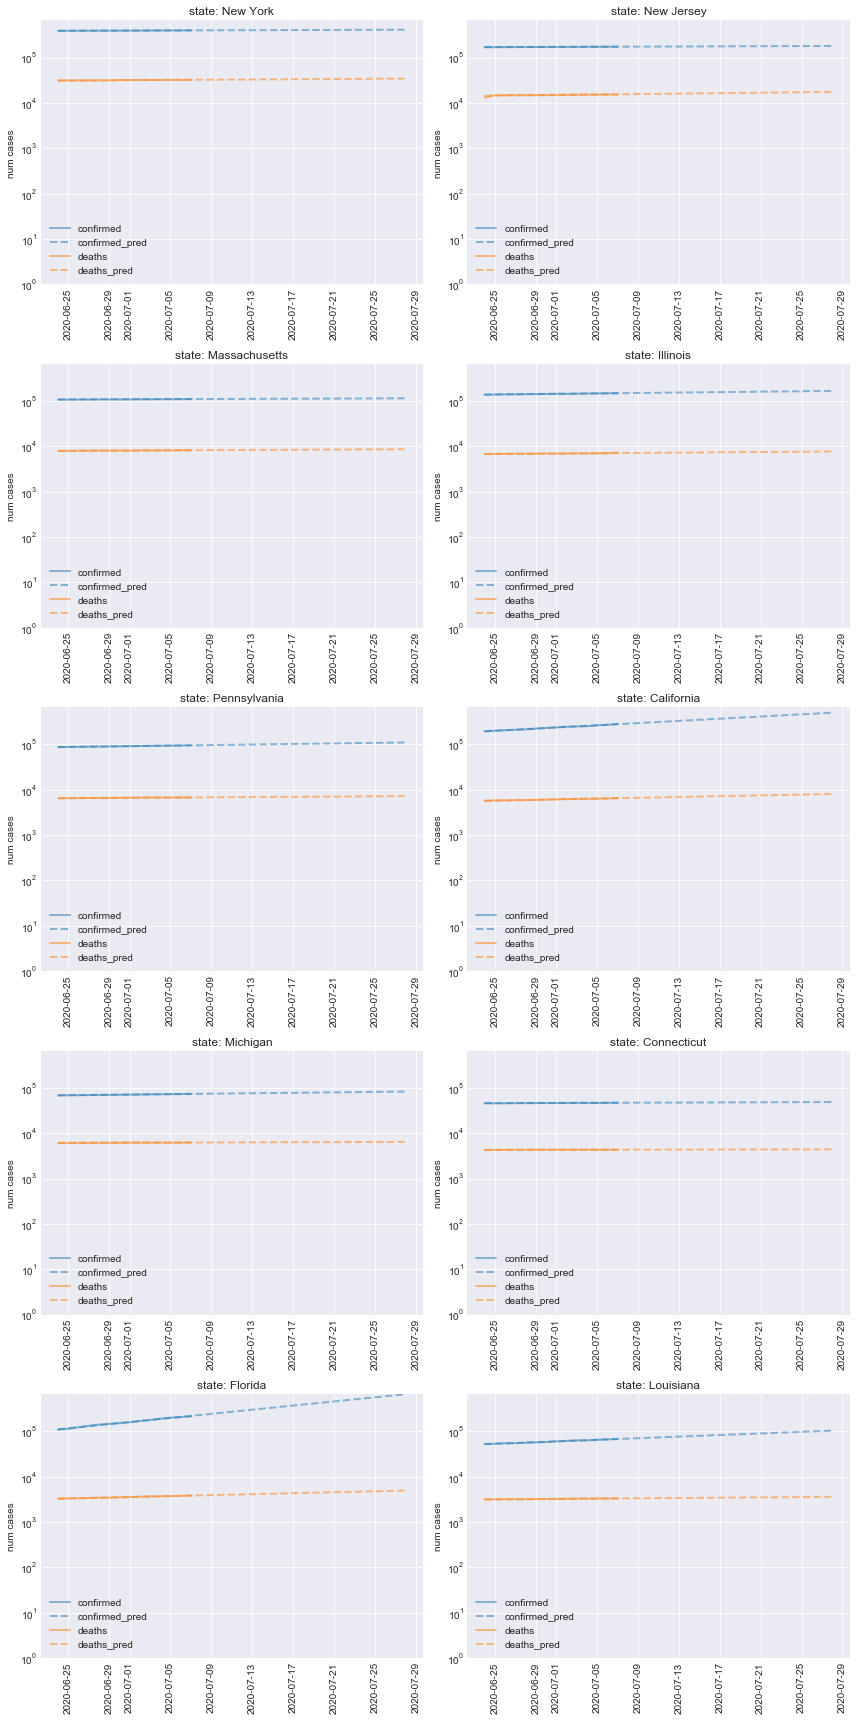

In [530]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [531]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [532]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'confirmed_new', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  confirmed_new  \
0  2020-07-07                Alaska       1180      17             18   
1  2020-07-07                  Utah      26033     194            564   
2  2020-07-07        South Carolina      47352     846            972   
3  2020-07-07                 Texas     216026    2778          10384   
4  2020-07-07               Arizona     105094    1927           3639   
5  2020-07-07             Tennessee      53514     665           1475   
6  2020-07-07              Arkansas      24512     301            259   
7  2020-07-07               Florida     213794    3841           7347   
8  2020-07-07                Hawaii       1071      19             41   
9  2020-07-07                Nevada      23785     548            876   
10 2020-07-07            California     284012    6573          12977   
11 2020-07-07                Oregon      10605     220            210   
12 2020-07-07           Mississippi      32214    1158            957   
13 2020-07-07                 Maine       3440     110             17   
14 2020-07-07               Montana       1327      23             78   
15 2020-07-07               Alabama      45785    1033            907   
16 2020-07-07              Virginia      66740    1881            638   
17 2020-07-07              Kentucky      17519     602            367   
18 2020-07-07              Missouri      24918    1067            707   
19 2020-07-07          South Dakota       7163      98             58   
20 2020-07-07            New Mexico      13727     519            220   
21 2020-07-07              Illinois     149574    7273           1709   
22 2020-07-07                Kansas      16860     289            222   
23 2020-07-07          North Dakota       3898      84             49   
24 2020-07-07                  Ohio      58904    2970            948   
25 2020-07-07               Wyoming       1709      21             34   
26 2020-07-07            Washington      37420    1384            435   
27 2020-07-07         New Hampshire       5932     384             18   
28 2020-07-07        North Carolina      76290    1446           1515   
29 2020-07-07              Oklahoma      17220     404            858   
30 2020-07-07                 Idaho       8539      94            487   
31 2020-07-07           Puerto Rico       8714     157            129   
32 2020-07-07             Louisiana      68263    3319           1936   
33 2020-07-07         West Virginia       3505      95             63   
34 2020-07-07               Indiana      48626    2717            102   
35 2020-07-07              Maryland      70396    3266            492   
36 2020-07-07             Wisconsin      32556     805            495   
37 2020-07-07                  Iowa      32153     732            395   
38 2020-07-07              Nebraska      20201     282            155   
39 2020-07-07         Massachusetts     110338    8213            201   
40 2020-07-07             Minnesota      39133    1514            564   
41 2020-07-07  District of Columbia      10569     561             54   
42 2020-07-07               Georgia     100470    2899           3406   
43 2020-07-07          Rhode Island      17154     969            163   
44 2020-07-07            New Jersey     173878   15281            267   
45 2020-07-07          Pennsylvania      95898    6787            798   
46 2020-07-07              Delaware      12414     514            121   
47 2020-07-07           Connecticut      47033    4338             57   
48 2020-07-07              New York     398237   32243            588   
49 2020-07-07              Michigan      73900    6251            633   
50 2020-07-07               Vermont       1254      56              3   
51 2020-07-07        Virgin Islands        116       6              4   
52 2020-07-07              Colorado      34647    1696            407   
53 2020-07-07                  Guam        303       5             

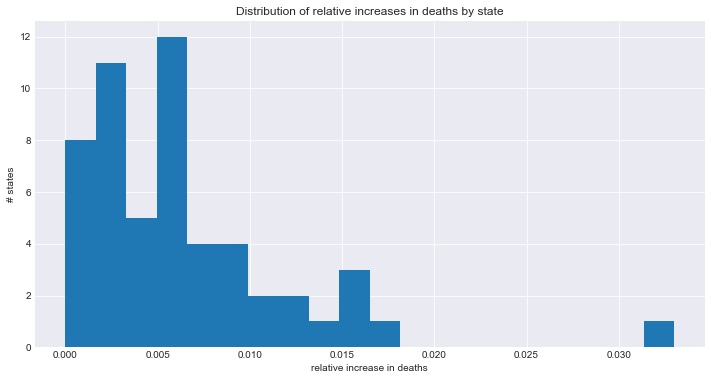

In [533]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

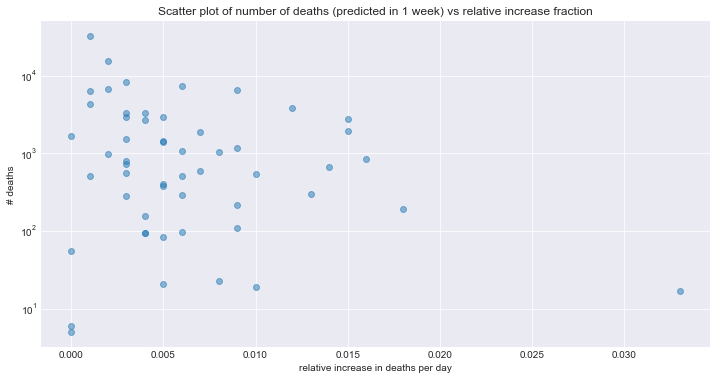

In [534]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [535]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

In [536]:
# _ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'Washington', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

In [537]:
# _ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
#                               'New York', 
#                               dfp=dfp_us_g, 
#                               country_col='state', 
#                               compare_col='confirmed'
#                              )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

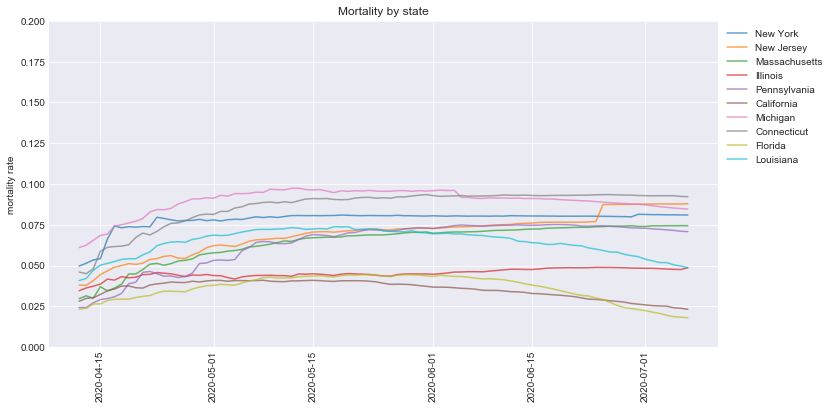

In [538]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

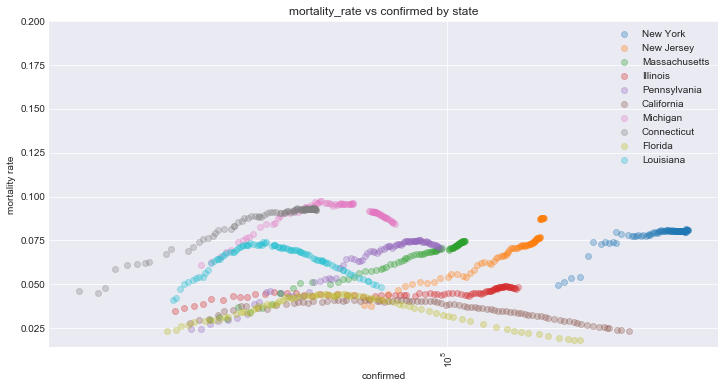

In [539]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

failed on 2020-04-01
failed on 2020-04-02
failed on 2020-04-03
failed on 2020-04-04
failed on 2020-04-05
failed on 2020-04-06
failed on 2020-04-07
failed on 2020-04-08
failed on 2020-04-09
failed on 2020-04-10
failed on 2020-04-11


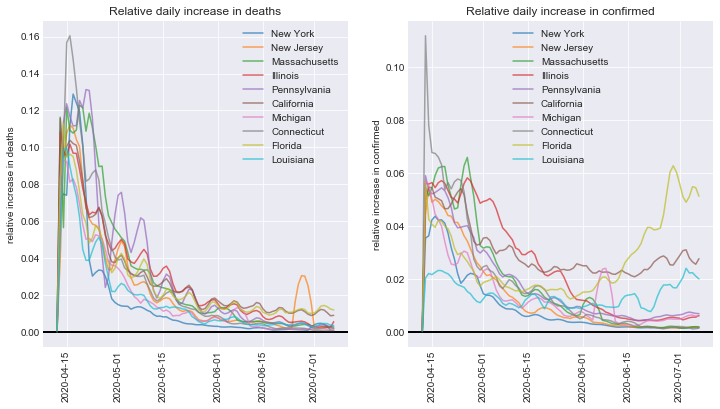

In [540]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [541]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n, cols_to_be_null_in_future=fit_cols)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                        n_countries=10, 
                        n_columns=2, 
                        figsize=(12,24), 
                        date_min=datetime.datetime(2020, 2, 1),
                        col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                       cols_deaths='deaths_new',
                       frac_increase_col='frac_increase_deaths',
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    else:
        n_countries = len(top_countries)
        
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={cols_deaths})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs[frac_increase_col].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest[f'{cols_deaths}_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [542]:
n_days_training = 21
dfp_us_g['deaths_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['deaths_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_g['confirmed_new_smooth'] = dfp_us_g.groupby(['country', 'state'], as_index=False)['confirmed_new'].rolling(7).mean().reset_index(0,drop=True)
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None,
                                                      fit_cols=['confirmed_new_smooth', 'deaths_new_smooth'],
                                                   )

confirmed_new_smooth_pred                                   \
date                         2020-07-08 2020-07-14 2020-07-21 2020-08-04   
state                                                                      
Florida                           11307      17763      30090      86337   
California                         7835       9980      13237      23284   
Louisiana                          1537       2192       3318       7600   
Illinois                            844        942       1070       1381   
Pennsylvania                        728        875       1085       1668   
New York                            642        631        620        597   
Michigan                            493        636        856       1549   
New Jersey                          297        290        283        269   
Massachusetts                       191        180        167        145   
Connecticut                          68         59         50         36   

                                                                       \
date          2020-09-01 2020-09-29 2020-10-27 2020-11-24  2020-12-22   
state                                                                   
Florida           710794    5851807   48176598  396626932  3265338968   
California         72044     222911     689704    2133997     6602744   
Louisiana          39867     209113    1096846    5753206    30176868   
Illinois            2302       3835       6389      10645       17736   
Pennsylvania        3943       9320      22027      52057      123030   
New York             553        513        476        441         409   
Michigan            5074      16616      54405     178134      583247   
New Jersey           243        219        198        178         161   
Massachusetts        109         82         61         46          34   
Connecticut           19         10          5          2           1   

                            deaths_new_smooth_pred                        \
date             2021-02-16             2020-07-08 2020-07-14 2020-07-21   
state                                                                      
Florida        221319872479                     47         54         63   
California         63209983                     65         66         68   
Louisiana         830238121                     13         13         13   
Illinois              49231                     20         15         11   
Pennsylvania         687171                     19         16         13   
New York                352                     93        120        160   
Michigan            6252606                      9          8          8   
New Jersey              131                     73         71         68   
Massachusetts            19                     16         13          9   
Connecticut               0                      2          1          0   

                                                                      \
date          2020-08-04 2020-09-01 2020-09-29 2020-10-27 2020-11-24   
state                                                                  
Florida               86        159        293        541        997   
California            72         81         90        100        112   
Louisiana             13         13         13         13         14   
Illinois               5          1          0          0          0   
Pennsylvania           9          4          2          1          0   
New York             287        923       2962       9506      30506   
Michigan               7          5          4          3          2   
New Jersey            64         55         48         41         36   
Massachusetts          5          1          0          0          0   
Connecticut            0          0          0          0          0   

                                    frac_increase_confirmed  \
date          2020-12-22 2021-02-16                           
state                  

In [543]:
#dfp_us_recent_1[dfp_us_recent_1.date == '2020-05-29'].sort_values(by='deaths_new_pred', ascending=0).reset_index(drop=True)

##### Fraction of increase in confirmed cases

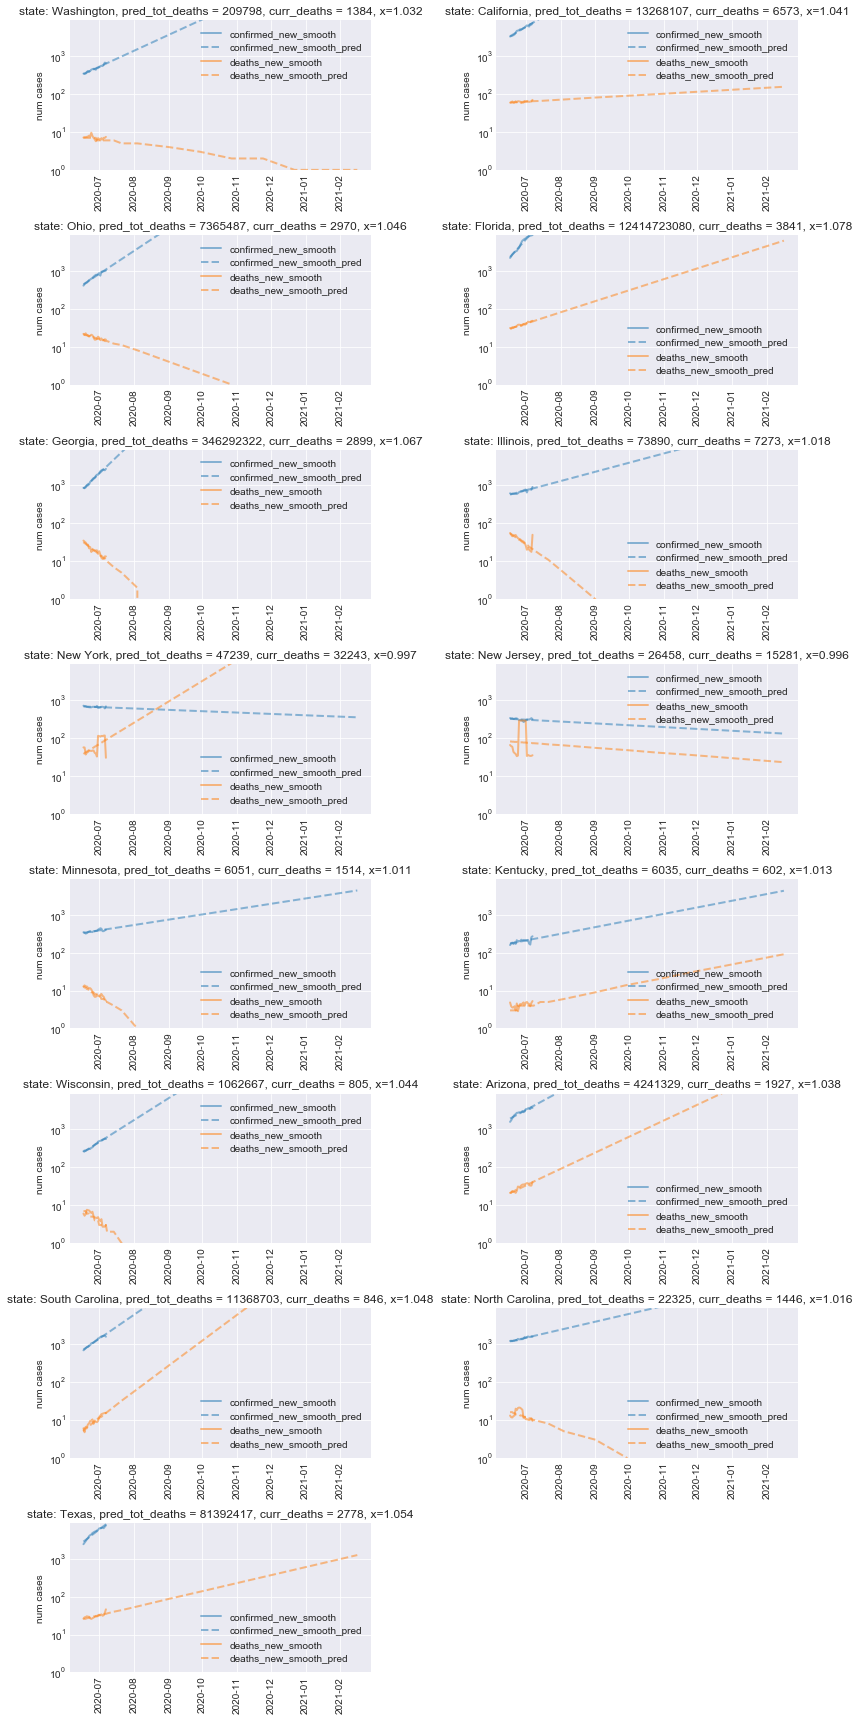

In [544]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
    frac_increase_col='frac_increase_confirmed'
)

##### Fraction increase in deaths_new

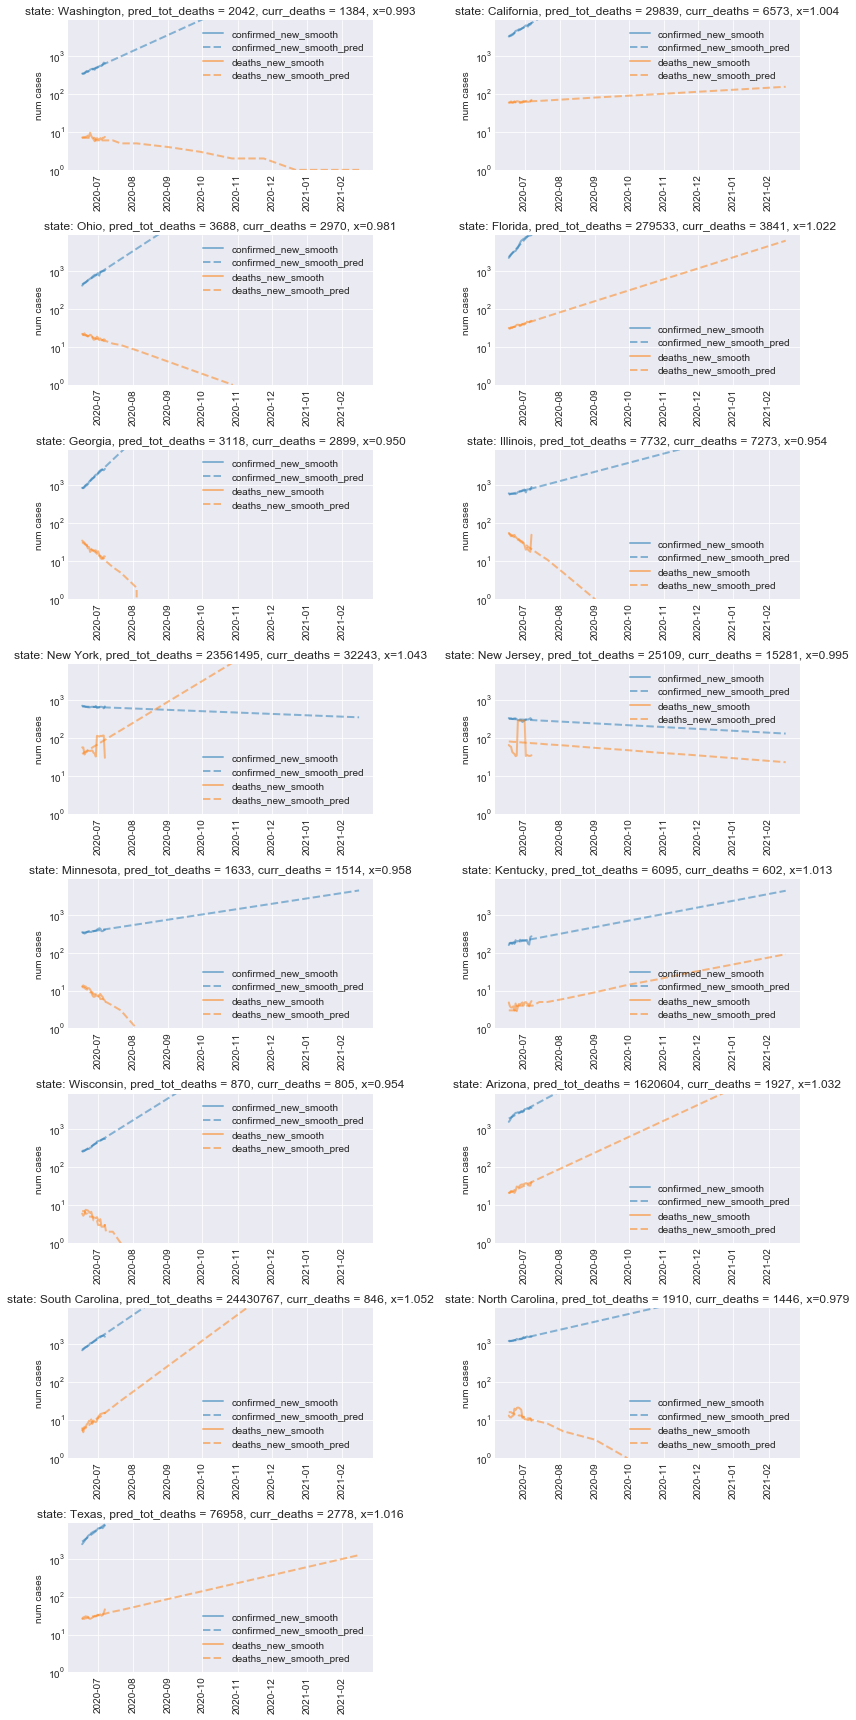

In [545]:
plot_forecasts_new(
    dfp_us_recent_1, 
    col_locale='state', 
    top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky', 'Wisconsin', 'Arizona', 'South Carolina', 'North Carolina', 'Texas'],
    cols_to_pred=['confirmed_new_smooth', 'deaths_new_smooth'],
    cols_deaths='deaths_new_smooth',
    frac_increase_col='frac_increase_deaths'
)

In [546]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-07-07_n_days_training=21.csv


<a id='us_state_smoothed_trend'></a>
### Plot trends

In [547]:
dfp_us_g_new_confirmed = dfp_us_g[dfp_us_g['date'] > datetime.datetime(2020,4,1)].groupby('state', as_index=False).agg({'confirmed_new': np.sum})
states_minimum_thresh = dfp_us_g_new_confirmed[(dfp_us_g_new_confirmed['confirmed_new'] > 100)].state

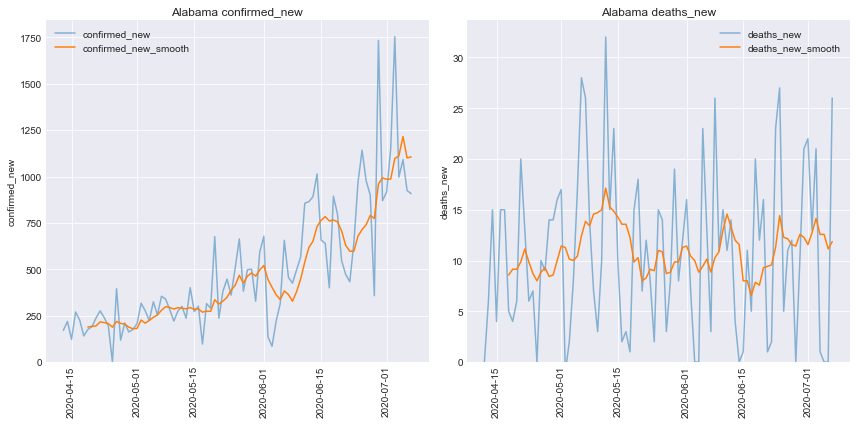

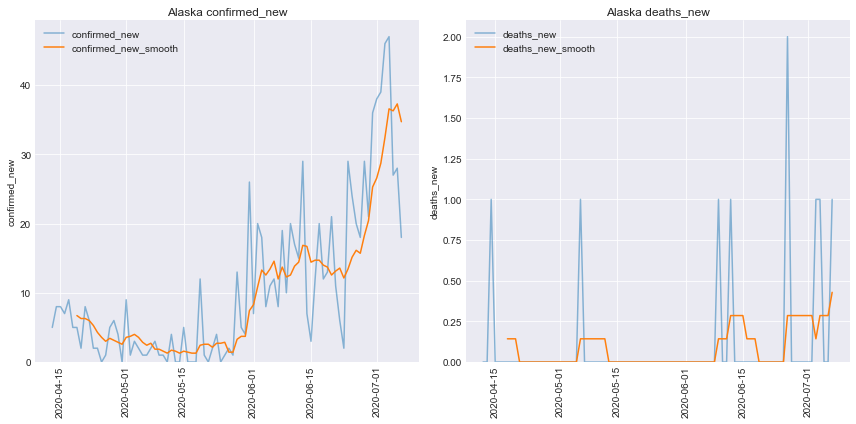

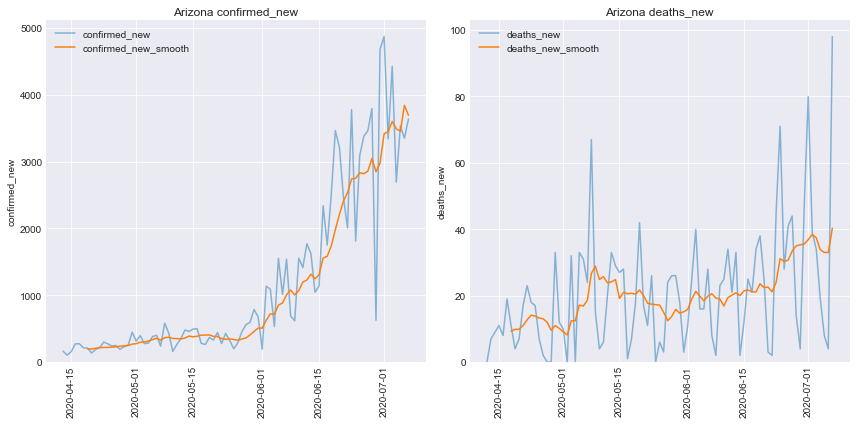

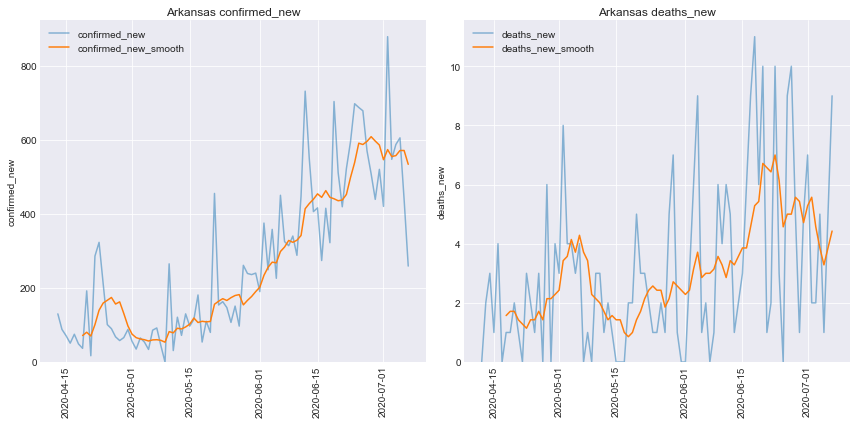

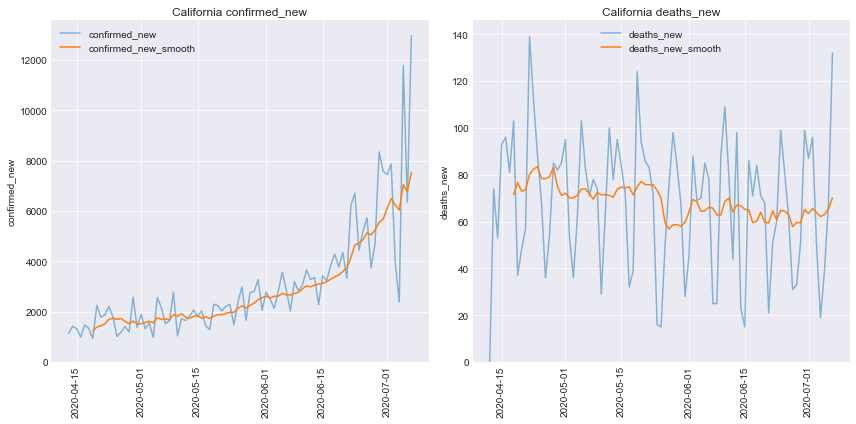

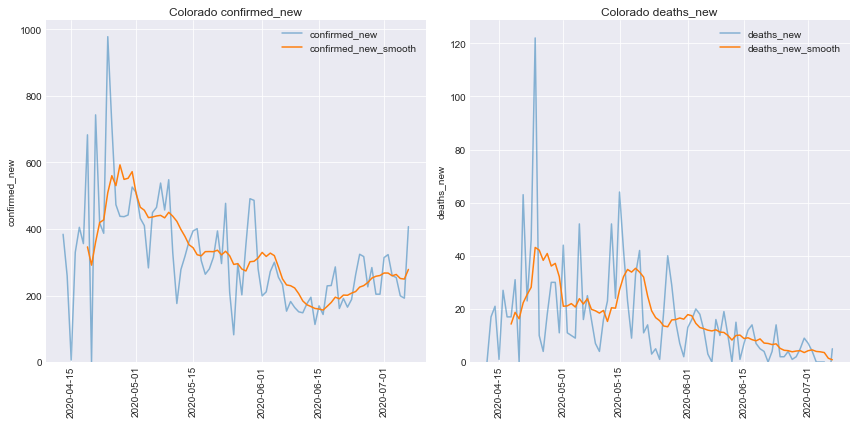

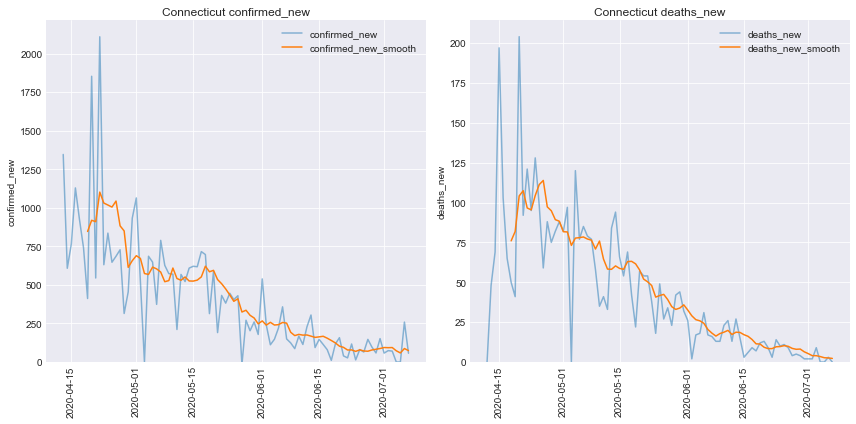

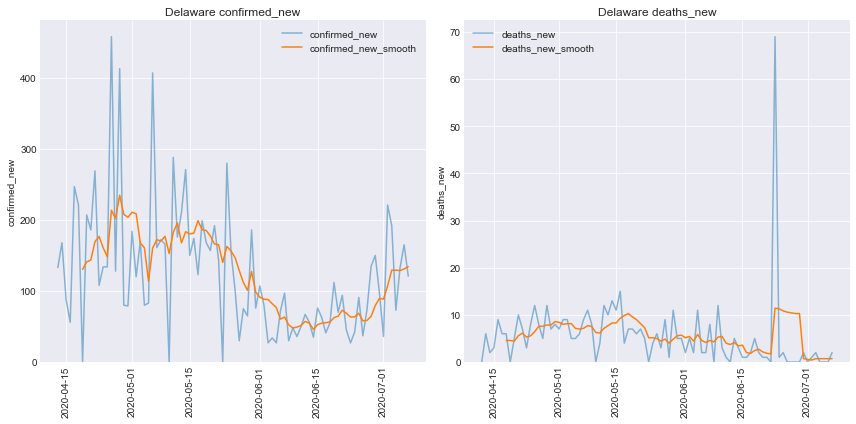

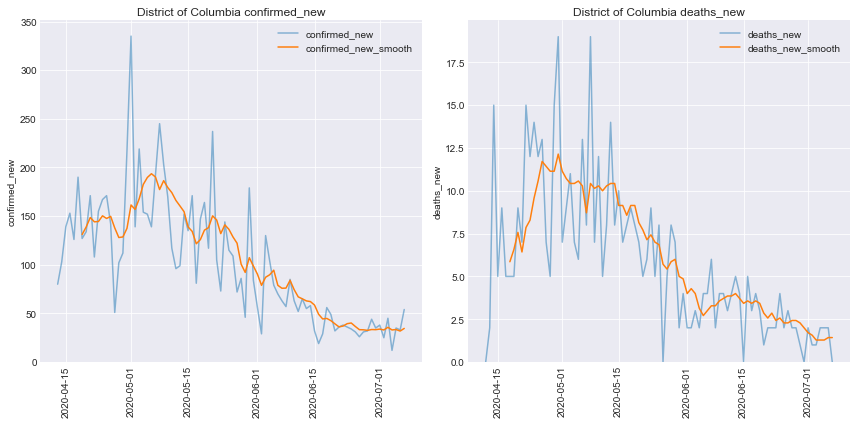

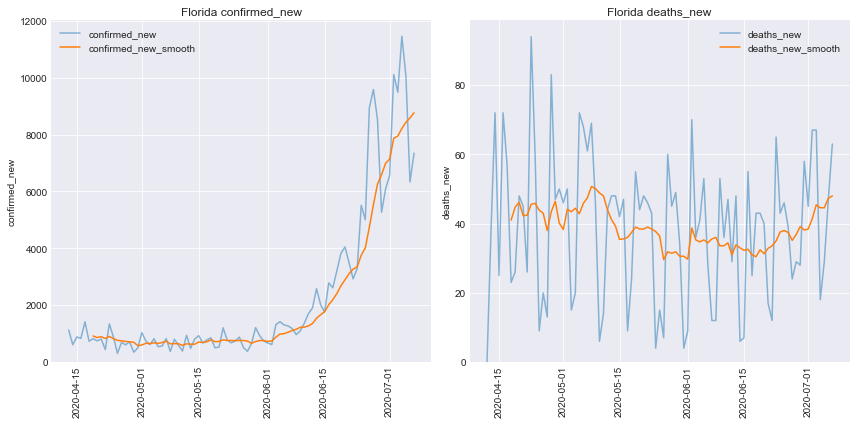

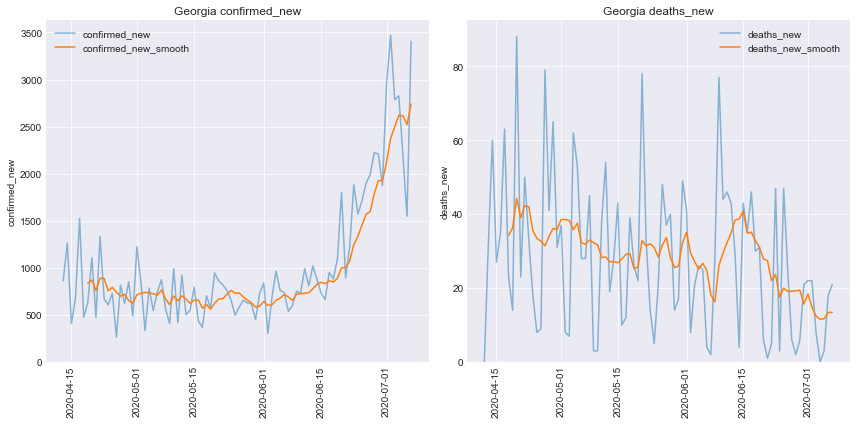

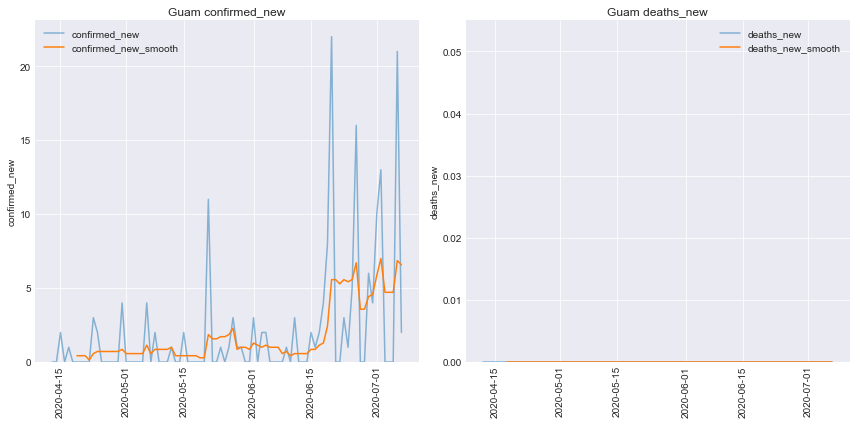

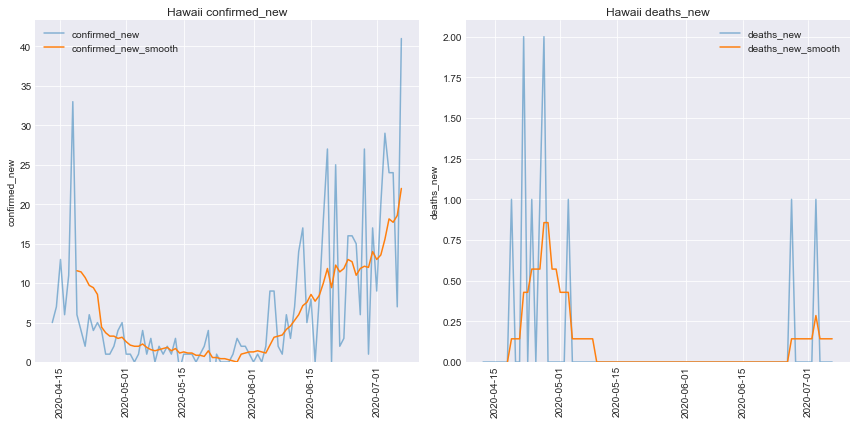

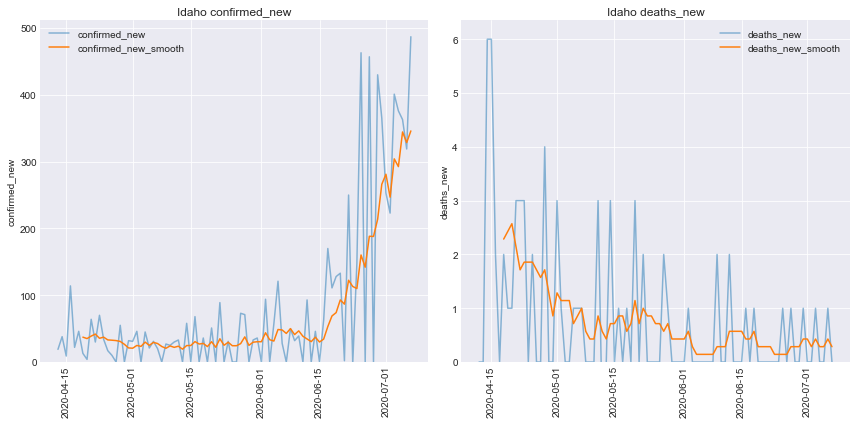

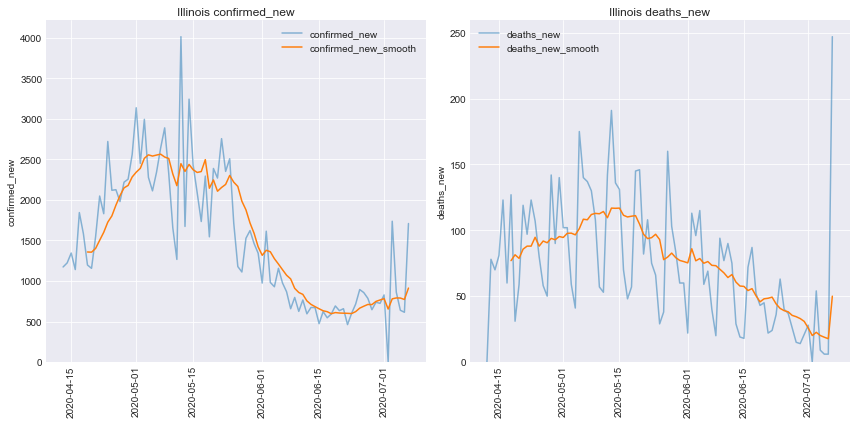

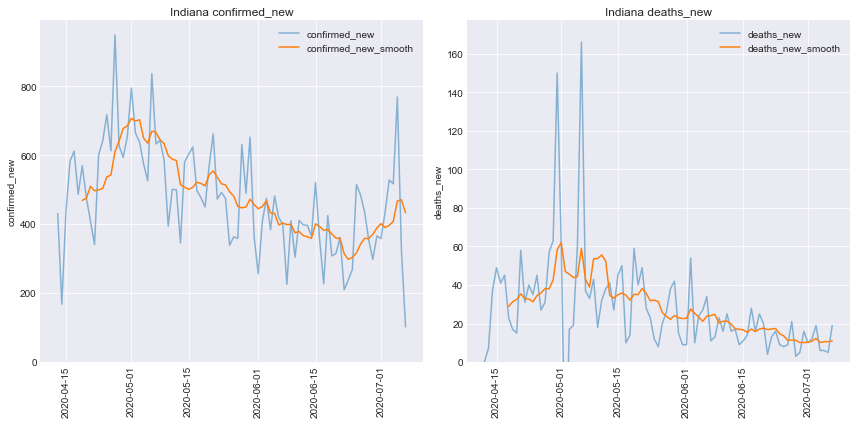

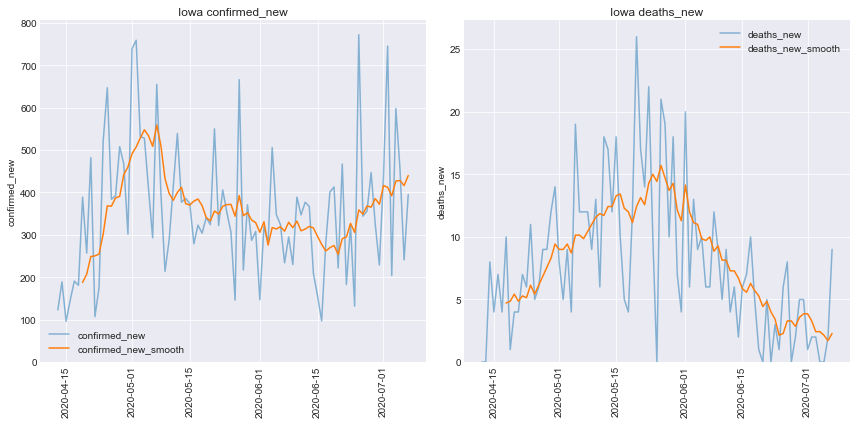

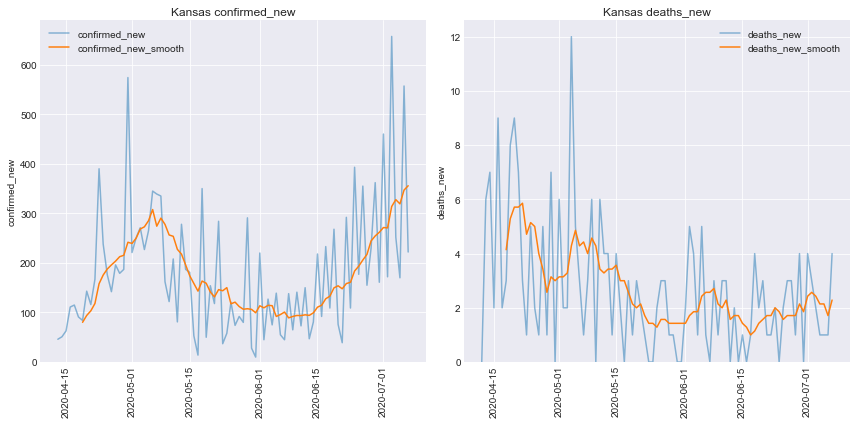

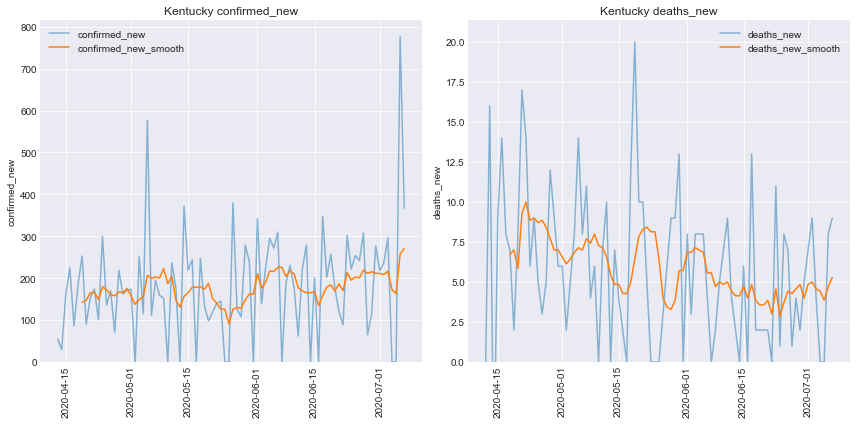

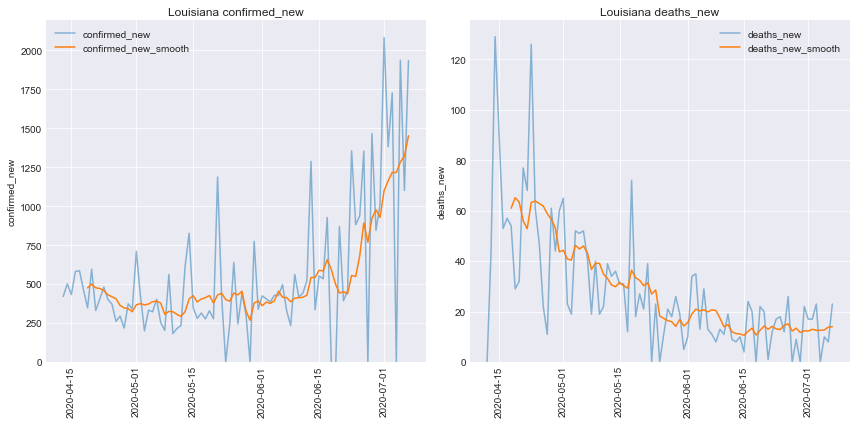

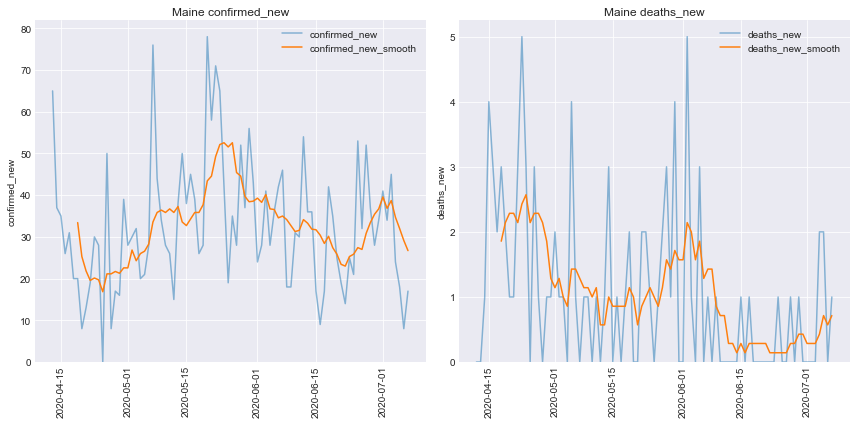

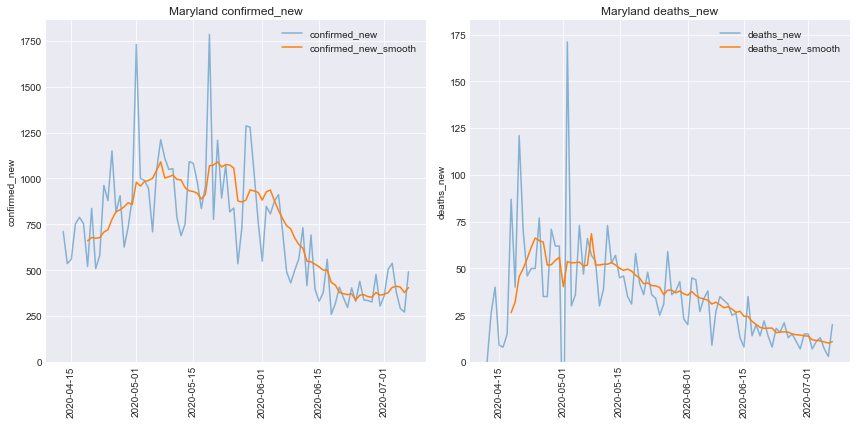

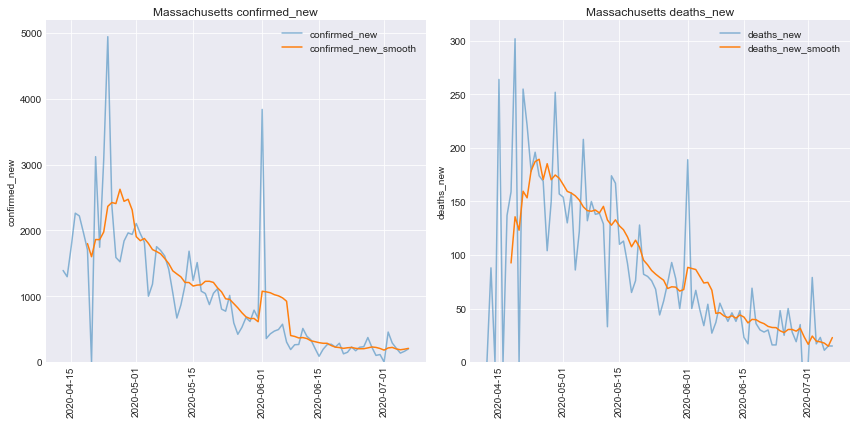

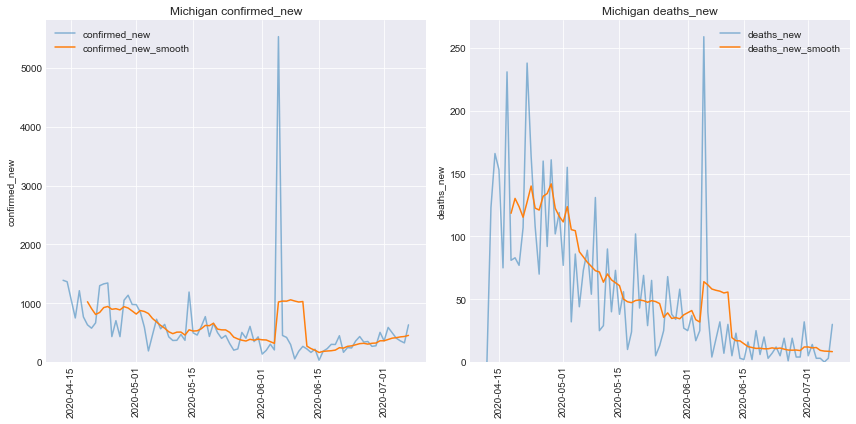

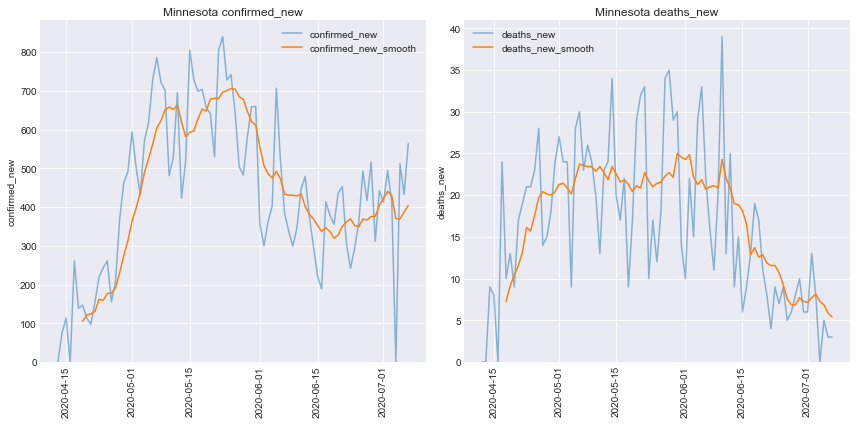

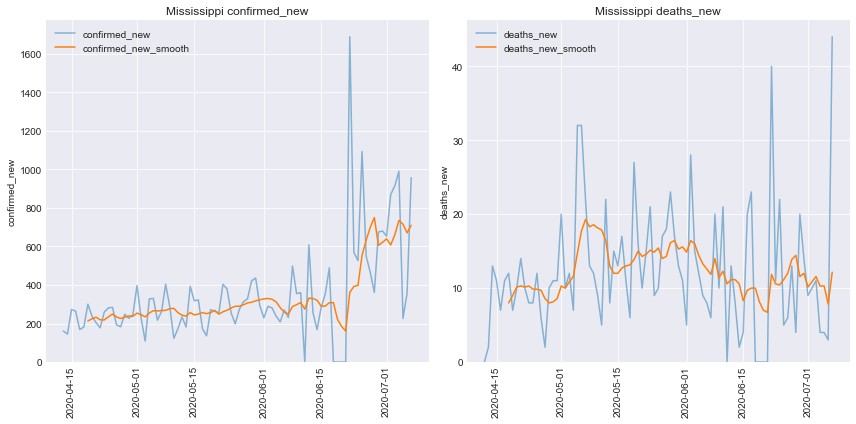

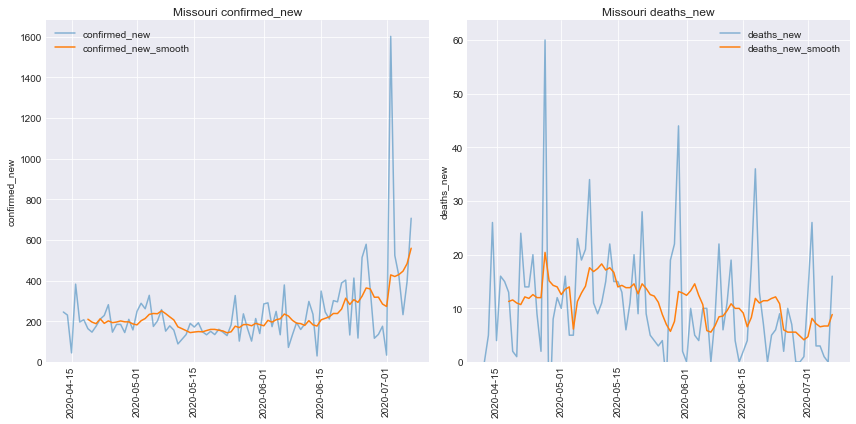

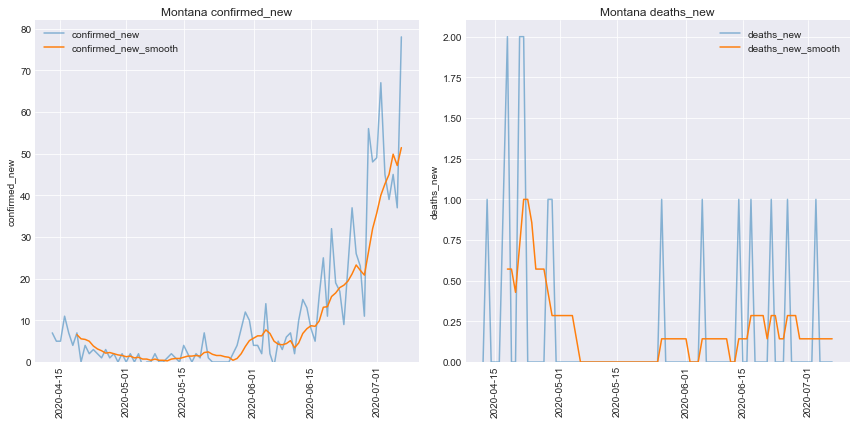

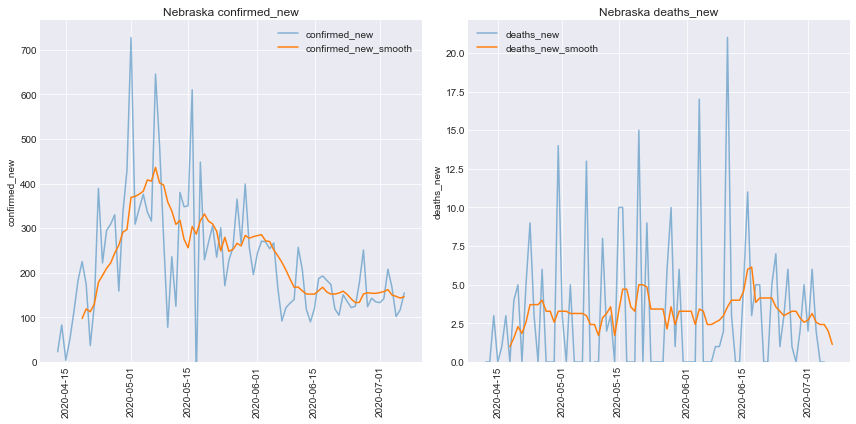

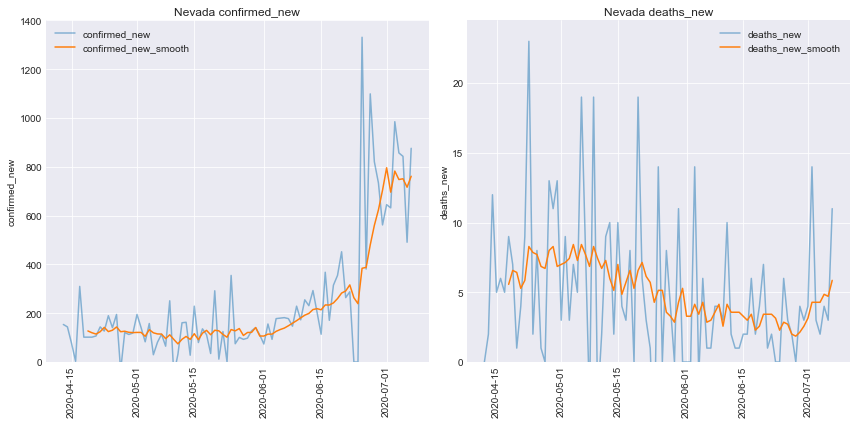

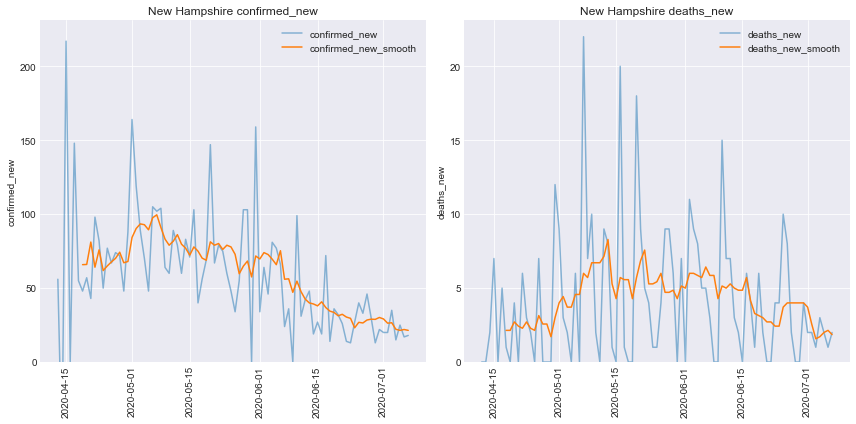

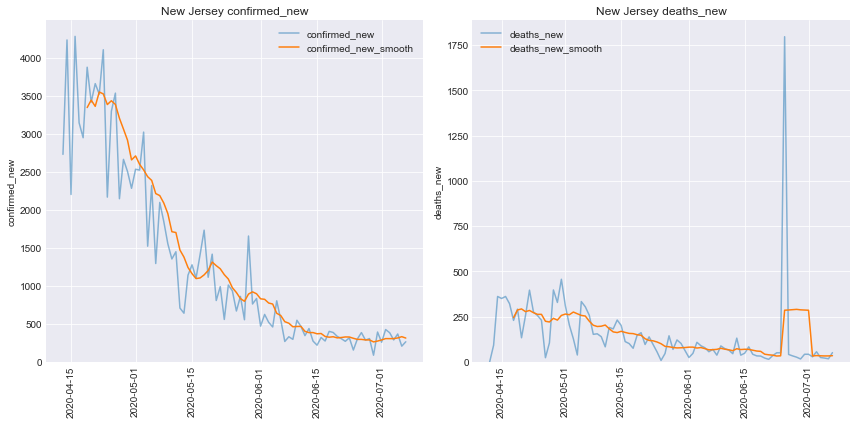

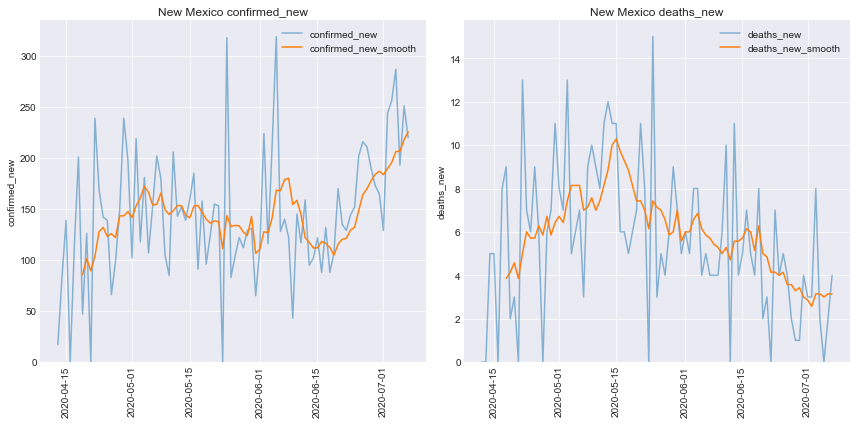

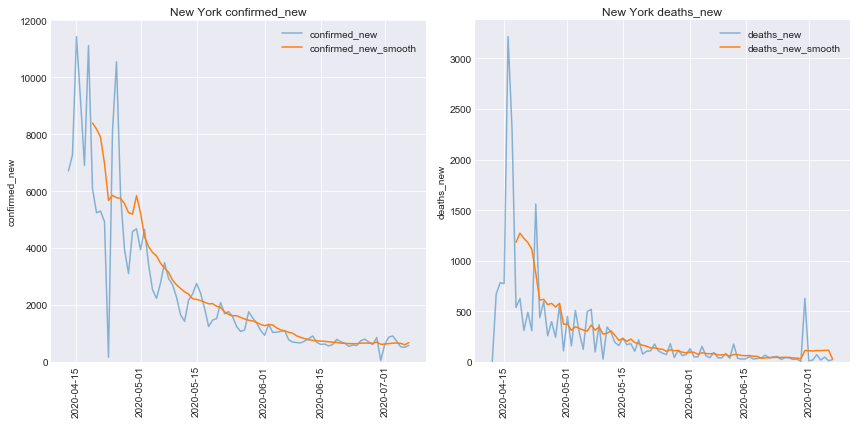

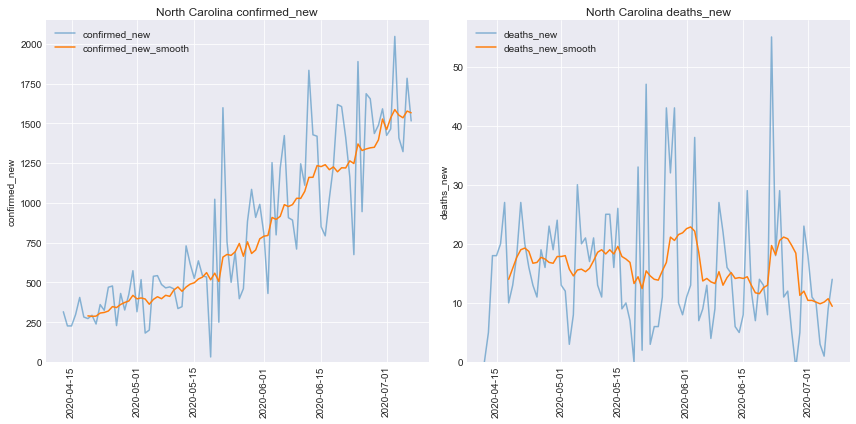

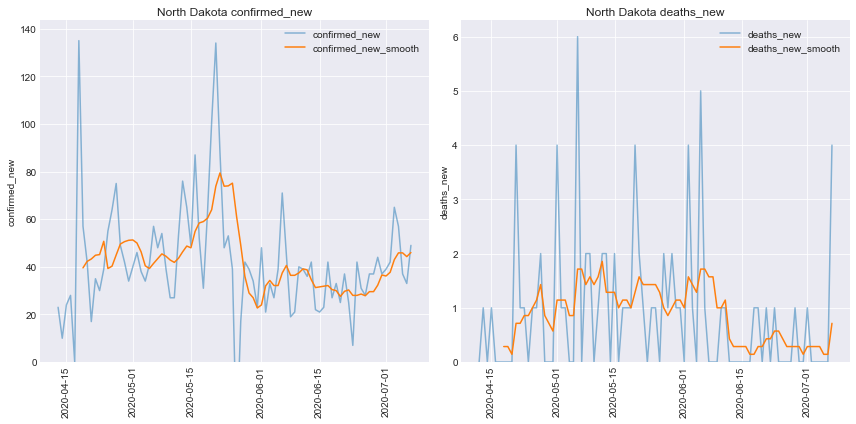

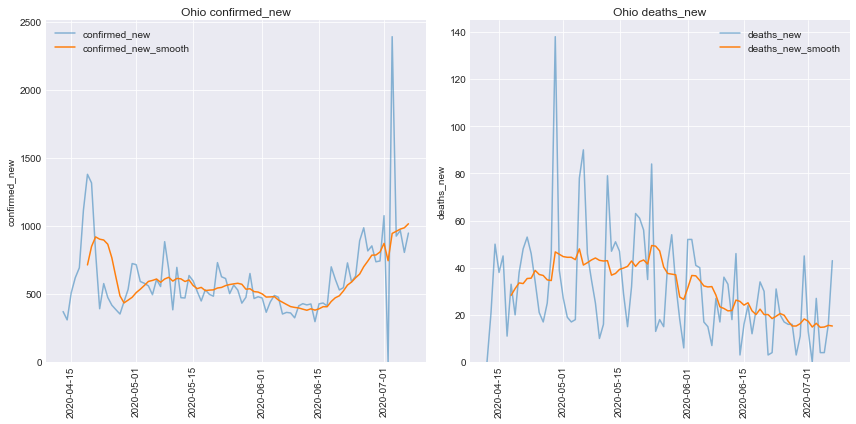

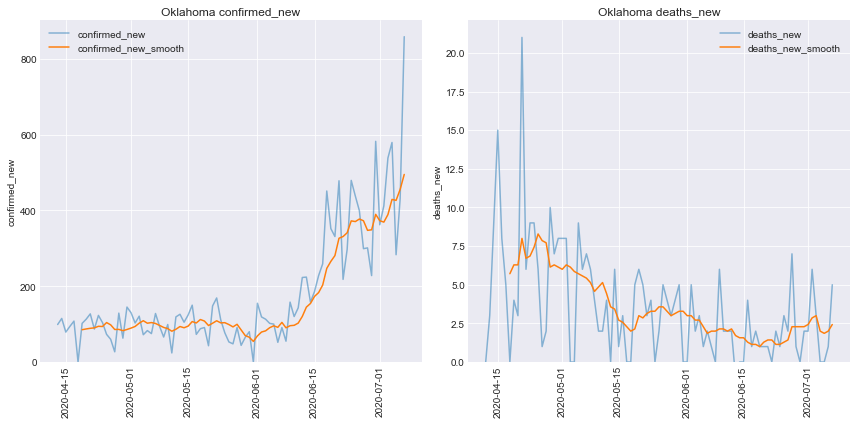

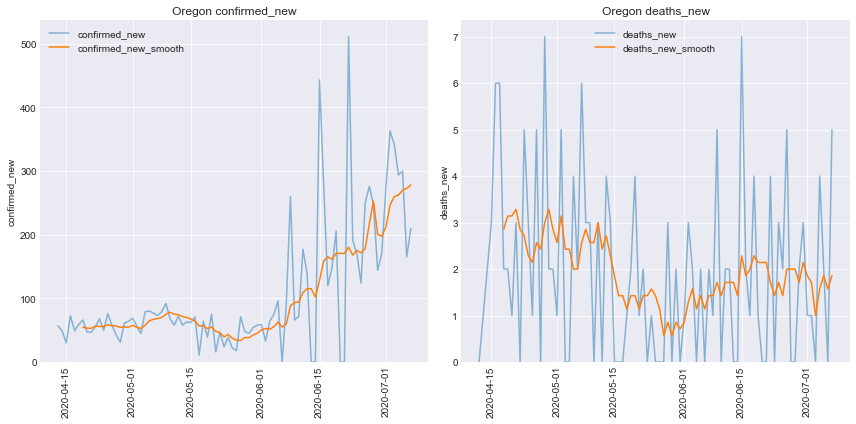

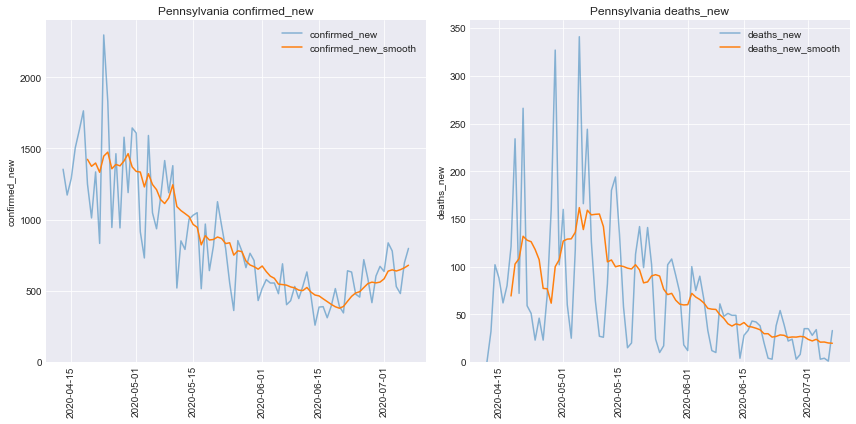

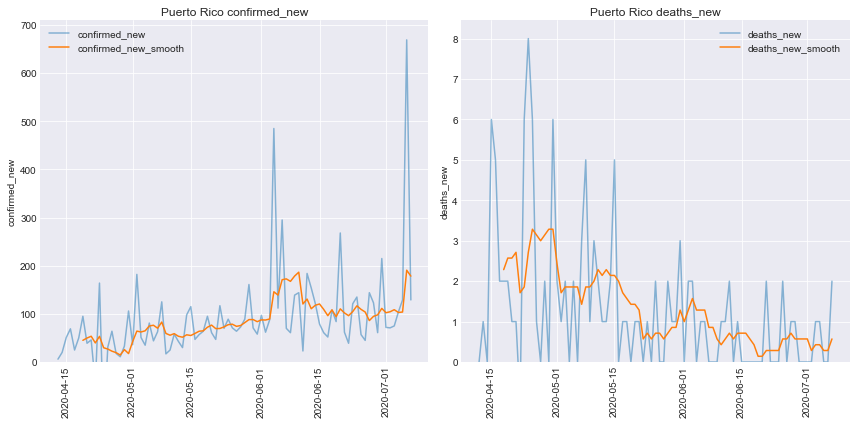

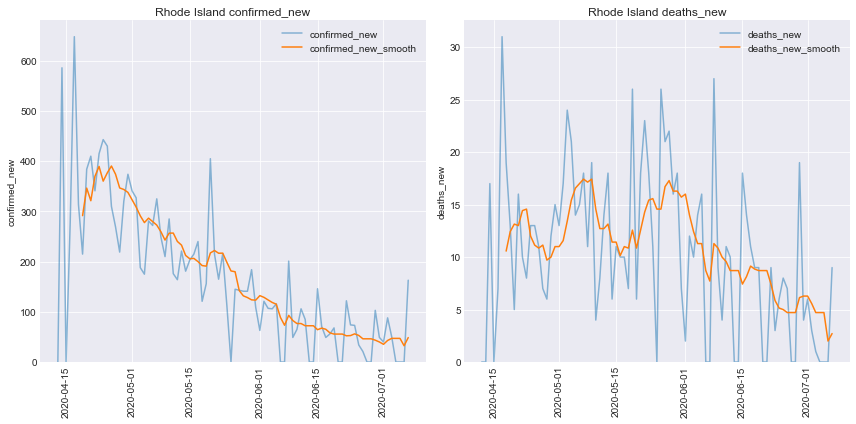

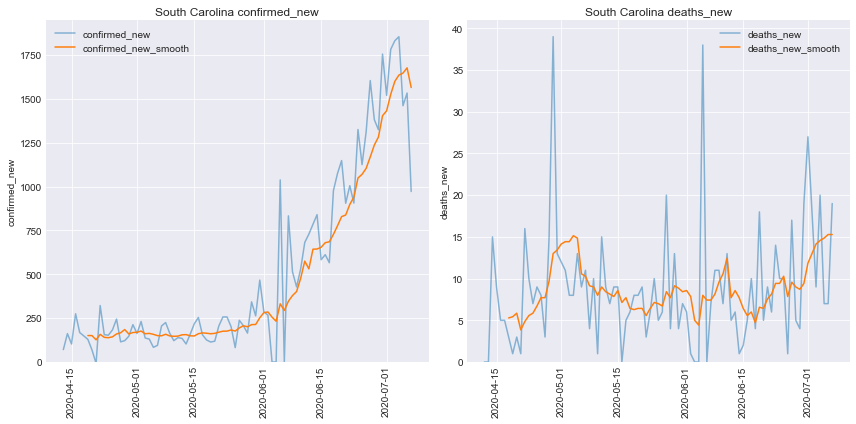

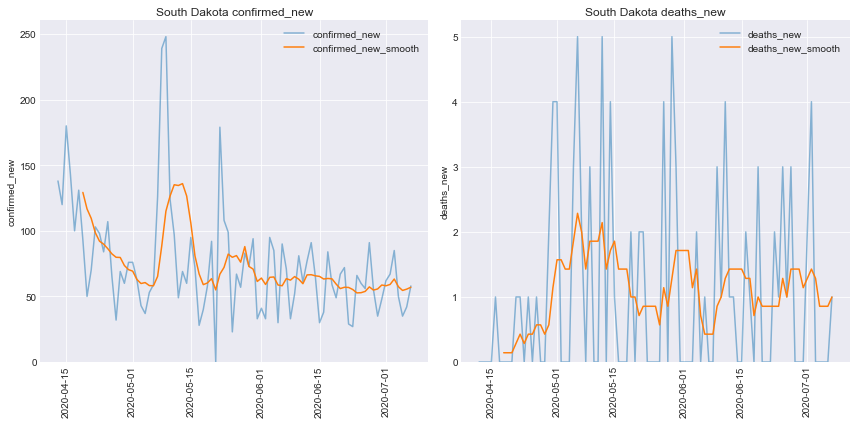

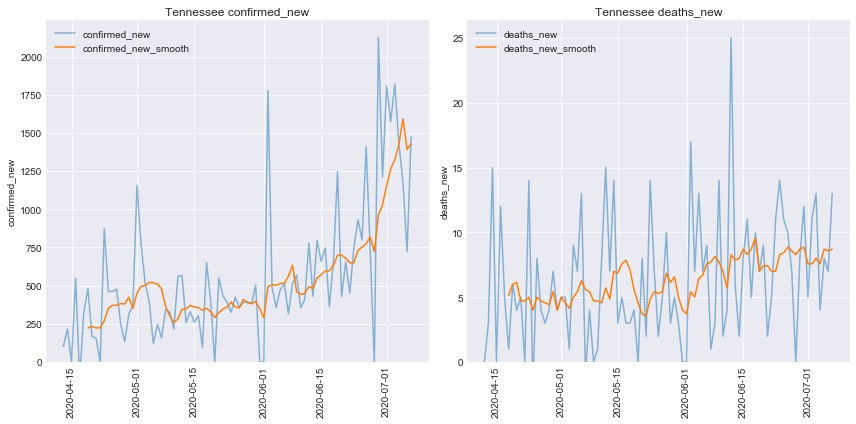

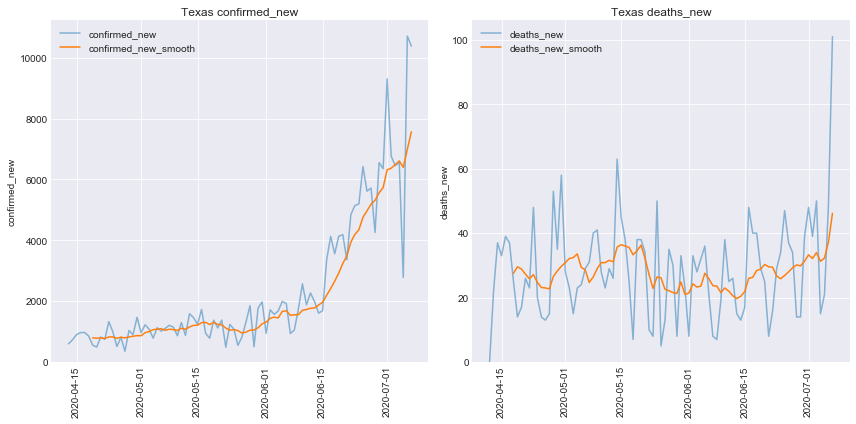

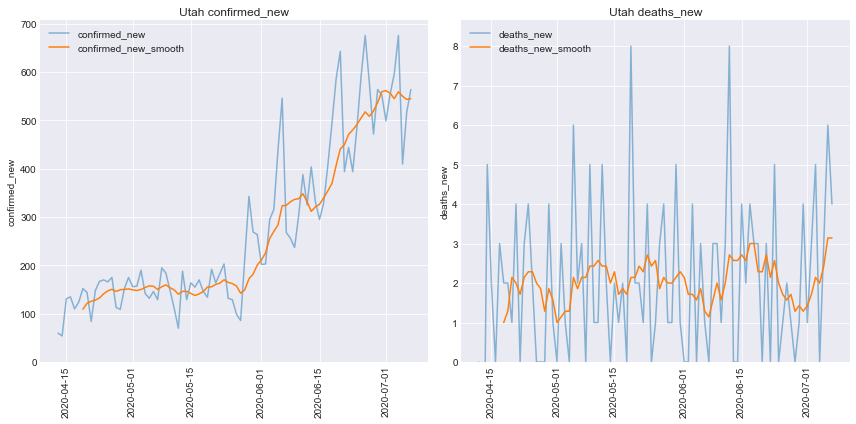

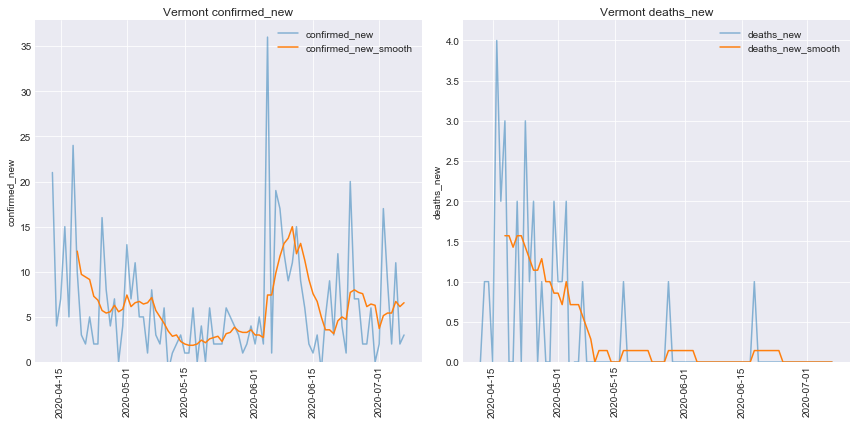

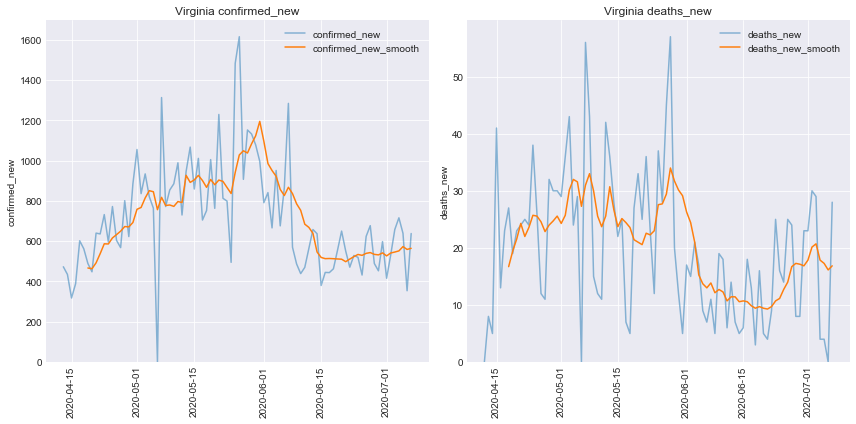

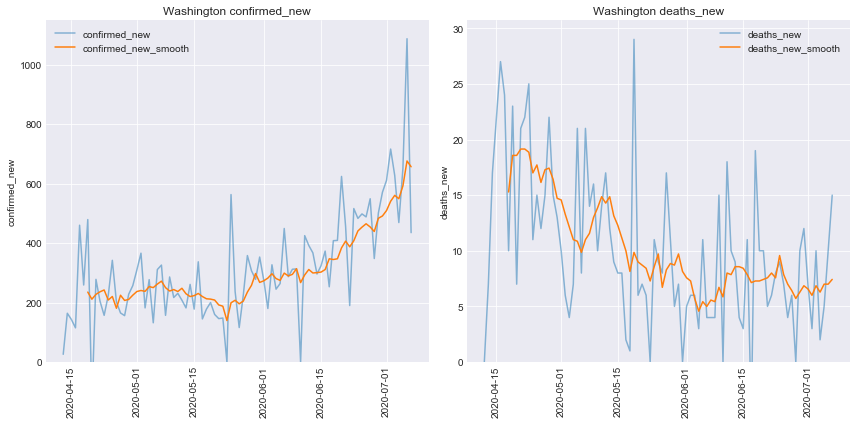

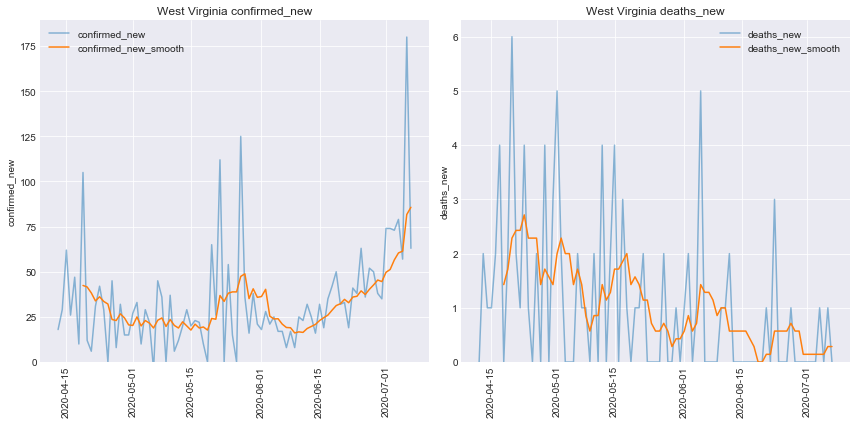

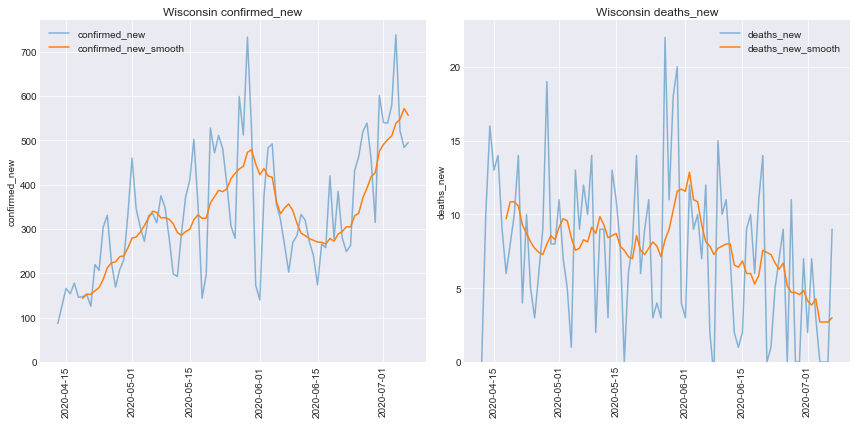

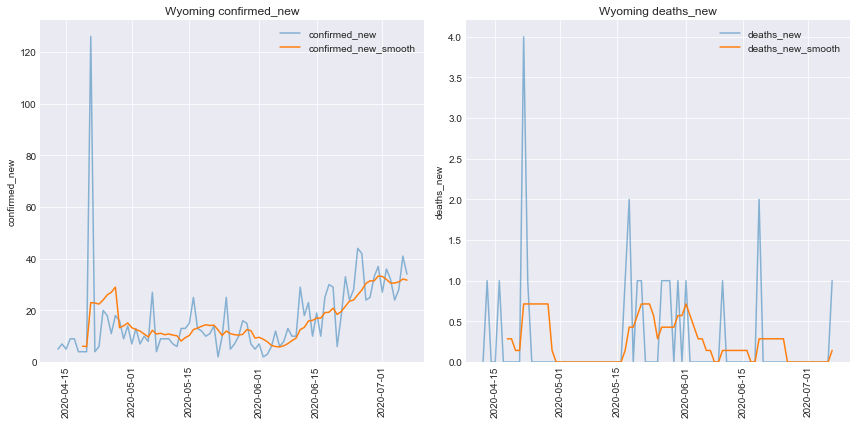

In [548]:
def plot_smoothed_trend(dfp_us_g, states, cols_plot=['confirmed_new'], dt_start=datetime.datetime(2020,3,1)):
    
    for state in states:
        i = 1
        for col_plot in cols_plot:
            plt.subplot(1,len(cols_plot),i)
            col_plot_smooth = f'{col_plot}_smooth'
            dfp_plot = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= dt_start)]
            plt.plot(dfp_plot['date'], dfp_plot[col_plot], alpha=0.5, label=col_plot)
            plt.plot(dfp_plot['date'], dfp_plot[col_plot_smooth], label=col_plot_smooth)
            plt.legend(loc='best')
            plt.xticks(rotation=90)
            plt.ylabel(col_plot)
            plt.title(f'{state} {col_plot}')
            plt.ylim(ymin=0)
            i += 1
        plt.tight_layout()
        plt.show()
    return None

#plot_smoothed_trend(dfp_us_g, ['Washington', 'Ohio', 'California', 'Texas', 'Minnesota', 'Wisconsin'], cols_plot=['confirmed_new', 'deaths_new'])

plot_smoothed_trend(dfp_us_g, states_minimum_thresh, cols_plot=['confirmed_new', 'deaths_new'])

### All states sorted by new deaths DESC

In [549]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Delaware              0.095369                 0.047255
1             South Carolina              0.051956                 0.047999
2                   New York              0.042519                -0.002685
3                   Virginia              0.042218                 0.005299
4                   Oklahoma              0.039734                 0.030389
5                    Arizona              0.032466                 0.037589
6                     Nevada              0.026812                 0.075072
7                    Alabama              0.024555                 0.031115
8                     Kansas              0.022396                 0.055105
9                    Florida              0.022084                 0.078197
10                     Texas              0.015982                 0.053793
11                  Kentucky              0.013291                 0.013222
12               Mississippi              0.010017                 0.065822
13                California              0.003925                 0.041164
14                 Tennessee              0.002918                 0.051187
15              South Dakota              0.000636                -0.001734
16                 Louisiana              0.000489                 0.060977
17  Northern Mariana Islands              0.000000                 0.000000
18              North Dakota              0.000000                 0.025460
19               Puerto Rico              0.000000                 0.015434
20                   Vermont              0.000000                 0.020239
21            Virgin Islands              0.000000                 0.025493
22             West Virginia              0.000000                 0.051401
23                   Montana              0.000000                 0.081254
24                    Alaska              0.000000                 0.063739
25                   Wyoming              0.000000                 0.031461
26                     Idaho              0.000000                 0.097004
27            American Samoa              0.000000                 0.000000
28                     Maine              0.000000                 0.014796
29          Diamond Princess              0.000000                 0.000000
30            Grand Princess              0.000000                 0.000000
31                      Guam              0.000000                 0.047443
32                    Hawaii              0.000000                 0.034092
33                New Jersey             -0.005024                -0.003655
34                Washington             -0.007384                 0.031778
35                    Oregon             -0.008025                 0.029843
36                      Utah             -0.008202                 0.019653
37                  Michigan             -0.009380                 0.043270
38                      Ohio             -0.019242                 0.046103
39                  Arkansas             -0.019813                 0.014076
40            North Carolina             -0.021399                 0.015891
41             New Hampshire             -0.025144                -0.021067
42              Pennsylvania             -0.026391                 0.031194
43                   Indiana             -0.030423                 0.012763
44                  Missouri             -0.030777                 0.035980
45                  Maryland             -0.034233                -0.002625
46                New Mexico             -0.035552                 0.039968
47             Massachusetts             -0.041362                -0.010134
48                 Minnesota             -0.041881                 0.010605
49                      Iowa             -0.043860                 0.028273
50                  Illinois             -0.045797                 0.018398
51                 Wisconsin             -0.046055                 0.04

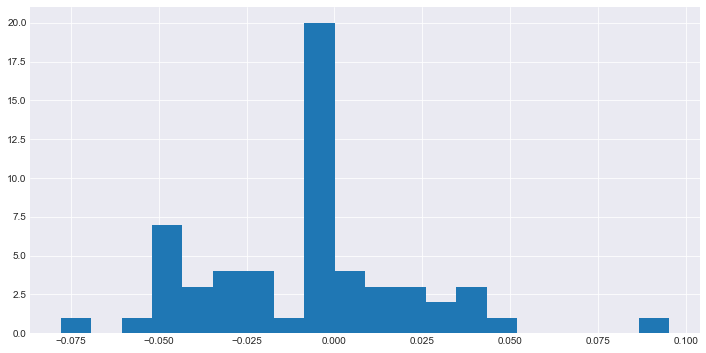

In [550]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

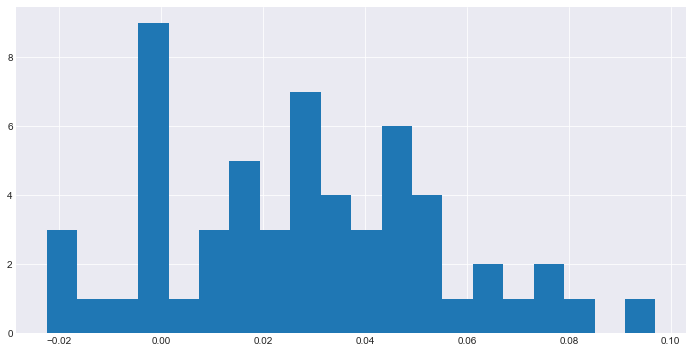

In [551]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [552]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0        Delaware              0.095369                 0.047255
1  South Carolina              0.051956                 0.047999
2        New York              0.042519                -0.002685
3        Virginia              0.042218                 0.005299
4        Oklahoma              0.039734                 0.030389
5         Arizona              0.032466                 0.037589
6          Nevada              0.026812                 0.075072
7         Alabama              0.024555                 0.031115
8          Kansas              0.022396                 0.055105
9         Florida              0.022084                 0.078197

### Which states are increasing in new deaths <u>least</u> quickly?

In [553]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48             Minnesota             -0.041881                 0.010605
49                  Iowa             -0.043860                 0.028273
50              Illinois             -0.045797                 0.018398
51             Wisconsin             -0.046055                 0.044042
52              Nebraska             -0.046753                -0.001919
53          Rhode Island             -0.048871                -0.020162
54  District of Columbia             -0.050217                -0.013835
55               Georgia             -0.050316                 0.067181
56              Colorado             -0.052838                 0.022755
57           Connecticut             -0.077977                -0.022420

### Is there a day-of-the-week effect on new deaths?

In [554]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [555]:
deaths_new_col, death_pred_col = 'deaths_new', 'deaths_new_smooth_pred'
confirmed_new_col, confirmed_pred_col = 'confirmed_new', 'confirmed_new_smooth_pred'
dfp_us_dow['death_delta'] = dfp_us_dow[deaths_new_col]- dfp_us_dow[death_pred_col]
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow[death_pred_col]

dfp_us_dow['confirmed_delta'] = dfp_us_dow[confirmed_new_col]- dfp_us_dow[confirmed_pred_col]
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow[confirmed_pred_col]
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.mean, # np.median
                          deaths_new_col: np.mean, 
                          death_pred_col: np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.mean}) # np.median
                    )

In [556]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0     2.333333         0.396825    8.666667   
379  Washington    1     5.333333         0.880952   11.666667   
380  Washington    2    -3.000000        -0.420635    3.666667   
381  Washington    3     3.000000         0.404762    9.666667   
382  Washington    4     1.333333         0.222222    8.000000   
383  Washington    5    -0.666667        -0.126984    6.000000   
384  Washington    6    -3.333333        -0.484127    3.333333   

     deaths_new_smooth_pred  confirmed_delta  confirmed_rel_delta  
378                6.333333        90.666667             0.086746  
379                6.333333       -10.000000             0.023180  
380                6.666667        20.000000             0.017486  
381                6.666667        98.000000             0.209650  
382                6.666667        51.333333             0.113156  
383                6.666667        76.333333             0.224478  
384                6.666667        -1.333333             0.001737

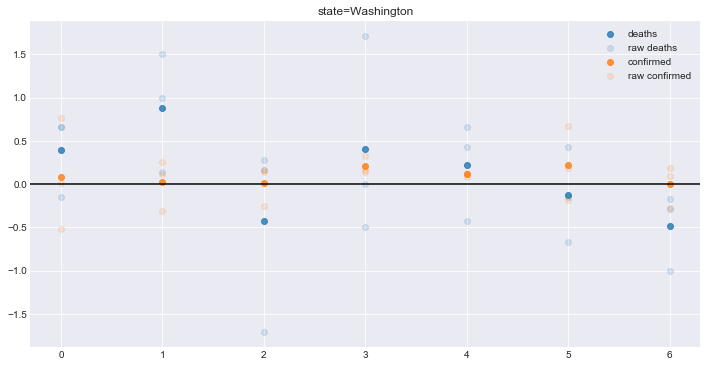

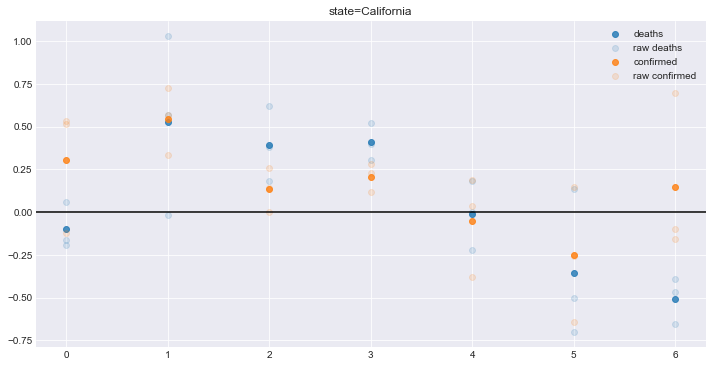

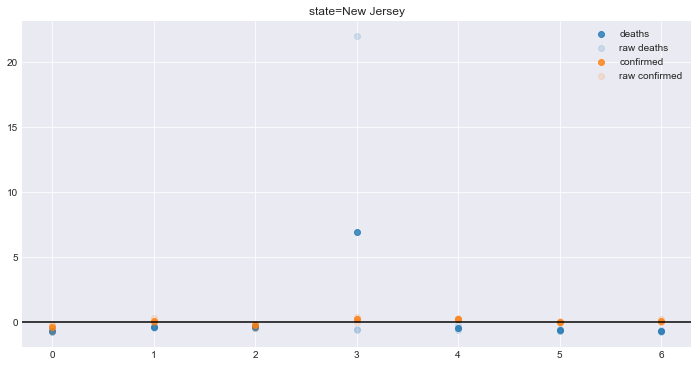

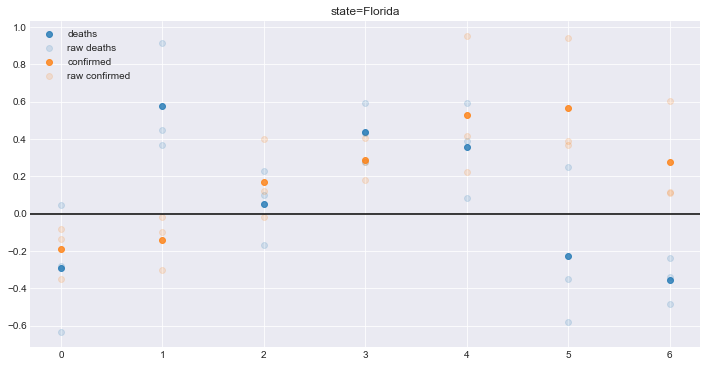

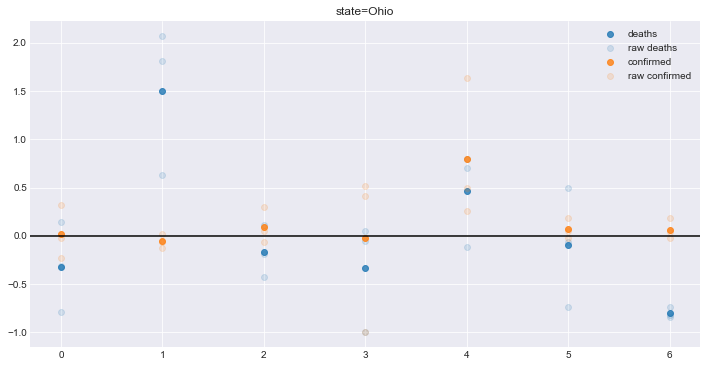

In [557]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()

# Cases per capita by state

In [558]:
dfp_state_census = pd.read_csv('supporting_data/nst-est2019-alldata.csv')

In [559]:
dfp_us_g.shape

(5064, 12)

In [560]:
cols_state_pop = ['NAME', 'POPESTIMATE2019'] #'STATE',
dfp_state_census_clean = dfp_state_census[cols_state_pop][dfp_state_census['STATE'] > 0]
#dfp_state_census_clean = dfp_state_census_clean.rename(columns={'STATE': 'STATE_NUMBER'})
dfp_state_census_clean.columns = [x.lower() for x in dfp_state_census_clean.columns]
pop_col = 'population'
cols_state_translate = {'name': 'state', 'popestimate2019': pop_col}
dfp_state_census_clean = dfp_state_census_clean.rename(columns=cols_state_translate)
dfp_us_g1 = dfp_us_g.copy()
dfp_us_g1 = dfp_us_g1.merge(dfp_state_census_clean, on='state', how='inner')

# add normalized columns
norm_factor = 1E6
dfp_us_g1['deaths_new_per_1m'] = dfp_us_g1['deaths_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m'] = dfp_us_g1['confirmed_new'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['deaths_new_per_1m_smooth'] = dfp_us_g1['deaths_new_smooth'] / dfp_us_g1[pop_col] * norm_factor
dfp_us_g1['confirmed_new_per_1m_smooth'] = dfp_us_g1['confirmed_new_smooth'] / dfp_us_g1[pop_col] * norm_factor

In [561]:
dfp_us_g1.shape

(4524, 17)

### Plot geo map of new cases

In [562]:
#plot_smoothed_trend(dfp_us_g1, states_minimum_thresh, cols_plot=['confirmed_new_per_1m', 'deaths_new_per_1m'])

In [563]:
# import shapefile as shp

In [564]:
# sns.set(style=”whitegrid”, palette=”pastel”, color_codes=True)
# sns.mpl.rc(“figure”, figsize=(10,6))

In [565]:
# # figure out which state numbers correspond to which states
# shape_data = []
# for i in range(100):
#     try:
#         shape_data.append((i, sf.shapeRecord(i).record[6]))
#     except Exception as e:
#         pass
# dfp_shape_data = pd.DataFrame(shape_data, columns=['state_number', 'state'])

# # merge state numbers with states for plotting purposes
# dfp_us_g1 = dfp_us_g1.merge(dfp_shape_data, on='state', how='left')

In [566]:
# def plot_map_fill_multiples_ids(
#     title, 
#     df,
#     plot_col,
#     sf,                                           
#     x_lim = None,                           
#     y_lim = None,                                       
#     figsize = (11,9),                                   
#     color = 'r'):
#     '''
#     Plot map with lim coordinates
#     '''
    
#     plt.figure(figsize = figsize)
#     fig, ax = plt.subplots(figsize = figsize)
#     fig.suptitle(title, fontsize=16)    
#     for shape in sf.shapeRecords():
#         shape = shape.shape
# #         x = [i[0] for i in shape.shape.points[:]]
# #         y = [i[1] for i in shape.shape.points[:]]
# #         ax.plot(x, y, 'k')
#         npoints = len(shape.points) # total points
#         nparts = len(shape.parts) # total parts
#         if nparts == 1:
#             x_lon = np.zeros((len(shape.points),1))
#             y_lat = np.zeros((len(shape.points),1))
#             for ip in range(len(shape.points)):
#                 x_lon[ip] = shape.points[ip][0]
#                 y_lat[ip] = shape.points[ip][1]
#             plt.plot(x_lon, y_lat, 'k')

#         else: # loop over parts of each shape, plot separately
#             for ip in range(nparts): # loop over parts, plot separately
#                 i0=shape.parts[ip]
#                 if ip < nparts-1:
#                     i1 = shape.parts[ip+1]-1
#                 else:
#                     i1 = npoints
#                 seg=shape.points[i0:i1+1]
#                 x_lon = np.zeros((len(seg),1))
#                 y_lat = np.zeros((len(seg),1))
#                 for ip in range(len(seg)):
#                     x_lon[ip] = seg[ip][0]
#                     y_lat[ip] = seg[ip][1]

#                 plt.plot(x_lon, y_lat, 'k')
#                 #ax.fill(x_lon, y_lat, color, alpha=alpha_val)
    
#     # find value to normalize the plot
#     norm_max = df[plot_col].max() * 0.9
#     norm_min = df[plot_col].min() * 1.1
    
    
#     for _, row in df.iterrows():
#         id = row['state_number']
#         val = row[plot_col]
#         shape_ex = sf.shape(id)
#         shape = sf.shape(id)
#         alpha_val = max(0, min(1, (val - norm_min) / (norm_max - norm_min)))
        
#         #for shape in list(sf.iterShapes()):
#         npoints = len(shape.points) # total points
#         nparts = len(shape.parts) # total parts
#         #print(f'For {row["state"]}, there are {nparts} parts')

#         if nparts == 1:
#             x_lon = np.zeros((len(shape.points),1))
#             y_lat = np.zeros((len(shape.points),1))
#             for ip in range(len(shape.points)):
#                 x_lon[ip] = shape.points[ip][0]
#                 y_lat[ip] = shape.points[ip][1]
#             #plt.plot(x_lon,y_lat)
#             ax.fill(x_lon, y_lat, color, alpha=alpha_val)

#         else: # loop over parts of each shape, plot separately
#             for ip in range(nparts): # loop over parts, plot separately
#                 i0=shape.parts[ip]
#                 if ip < nparts-1:
#                     i1 = shape.parts[ip+1]-1
#                 else:
#                     i1 = npoints
#                 seg=shape.points[i0:i1+1]
#                 x_lon = np.zeros((len(seg),1))
#                 y_lat = np.zeros((len(seg),1))
#                 for ip in range(len(seg)):
#                     x_lon[ip] = seg[ip][0]
#                     y_lat[ip] = seg[ip][1]

#                 #plt.plot(x_lon,y_lat)
#                 ax.fill(x_lon, y_lat, color, alpha=alpha_val)

# #         x_lon = np.zeros((len(shape_ex.points),1))
# #         y_lat = np.zeros((len(shape_ex.points),1))
# #         for ip in range(len(shape_ex.points)):
# #             x_lon[ip] = shape_ex.points[ip][0]
# #             y_lat[ip] = shape_ex.points[ip][1]
            
#         #alpha_val = max(0, min(1, (val - norm_min) / (norm_max - norm_min)))
#         #ax.fill(x_lon,y_lat, color, alpha=alpha_val)
             
# #         x0 = np.mean(x_lon)
# #         y0 = np.mean(y_lat)
#         #plt.text(x0, y0, id, fontsize=10)
    
#     if (x_lim != None) & (y_lim != None):     
#         plt.xlim(x_lim)
#         plt.ylim(y_lim)

In [567]:
# sns.set(style='whitegrid', palette='pastel', color_codes=True)

# dfp_us_g1_newest = dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()]

# shp_path = "supporting_data/tl_2019_us_state/tl_2019_us_state.shp"
# sf = shp.Reader(shp_path)# Continental US


# y_lim = (23, 50) # lat 
# x_lim = (-128, -65) # longstate_id = [0, 10, 3, 5, 6, 7, 8, 30]

# plot_col = 'confirmed_new_per_1m_smooth'
# plot_map_fill_multiples_ids(
#     plot_col,
#     dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()], 
#     plot_col,
#     sf, 
#     x_lim, 
#     y_lim, 
#     color = 'r', 
#     figsize = (15,9)
# )

In [568]:
# plot_col = 'deaths_new_per_1m_smooth'
# plot_map_fill_multiples_ids(
#     plot_col,
#     dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()], 
#     plot_col,
#     sf, 
#     x_lim, 
#     y_lim, 
#     color = 'r', 
#     figsize = (15,9)
# )

### Plotly geomap

In [569]:
dfp_us_g1_newest = dfp_us_g1[dfp_us_g1.date == dfp_us_g1.date.max()].copy()
#print(f'There are {len(dfp_us_g1_newest.columns)}')
cols1 = set(dfp_us_g1_newest.columns)
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_state_codes, left_on='state', right_on='state_name', how='left')
#print(f'After merge there are {len(dfp_us_g1_newest.columns)}')
cols2 = set(dfp_us_g1_newest.columns)

In [570]:
dfp_us_g1_newest = dfp_us_g1_newest.sort_values(by='confirmed_new_per_1m_smooth', ascending=0)
dfp_us_g1_newest.head(10)

date country           state  confirmed  deaths  confirmed_lag1  \
29 2020-07-07      US         Arizona     105094    1927        101455.0   
36 2020-07-07      US         Florida     213794    3841        206447.0   
46 2020-07-07      US       Louisiana      68263    3319         66327.0   
13 2020-07-07      US  South Carolina      47352     846         46380.0   
16 2020-07-07      US           Texas     216026    2778        205642.0   
37 2020-07-07      US         Georgia     100470    2899         97064.0   
1  2020-07-07      US          Nevada      23785     548         22909.0   
27 2020-07-07      US     Mississippi      32214    1158         31257.0   
0  2020-07-07      US         Alabama      45785    1033         44878.0   
15 2020-07-07      US       Tennessee      53514     665         52039.0   

    deaths_lag1  confirmed_new  deaths_new  mortality_rate  deaths_new_smooth  \
29       1829.0         3639.0        98.0        0.018336          40.285714   
36       3778.0         7347.0        63.0        0.017966          48.000000   
46       3296.0         1936.0        23.0        0.048621          14.000000   
13        827.0          972.0        19.0        0.017866          15.285714   
16       2677.0        10384.0       101.0        0.012860          46.142857   
37       2878.0         3406.0        21.0        0.028854          13.428571   
1         537.0          876.0        11.0        0.023040           5.857143   
27       1114.0          957.0        44.0        0.035947          12.142857   
0        1007.0          907.0        26.0        0.022562          11.857143   
15        652.0         1475.0        13.0        0.012427           8.714286   

    confirmed_new_smooth  population  deaths_new_per_1m  confirmed_new_per_1m  \
29           3695.142857     7278717          13.463911            499.950747   
36           8765.714286    21477737           2.933270            342.075145   
46           1452.571429     4648794           4.947520            416.452095   
13           1564.714286     5148714           3.690242            188.785005   
16           7566.571429    28995881           3.483253            358.119831   
37           2739.857143    10617423           1.977881            320.793473   
1             761.285714     3080156           3.571248            284.401180   
27            709.571429     2976149          14.784206            321.556481   
0            1105.714286     4903185           5.302676            184.981803   
15           1429.285714     6829174           1.903598            215.985125   

    deaths_new_per_1m_smooth  confirmed_new_per_1m_smooth      state_name  \
29                  5.534727                   507.664037         Arizona   
36                  2.234872                   408.130255         Florida   
46                  3.011534                   312.461991       Louisiana   
13                  2.968841                   303.903904  South Carolina   
16                  1.591359                   260.953321           Texas   
37                  1.264767                   258.052933         Georgia   
1                   1.901573                   247.158168          Nevada   
27                  4.080057                   238.419323     Mississippi   
0                   2.418253                   225.509396         Alabama   
15                  1.276038                   209.291155       Tennessee   

   two_letter_code  
29              AZ  
36              FL  
46              LA  
13              SC  
16              TX  
37              GA  
1               NV  
27              MS  
0               AL  
15              TN

In [571]:
def plot_us_map(df, plot_col, color='Reds', col_state_abbrev='two_letter_code'):
    # this was adapted from example at https://plotly.com/python/choropleth-maps/
    import plotly.graph_objects as go
    fig = go.Figure(data=go.Choropleth(
        locations=df[col_state_abbrev], #df['code'], # Spatial coordinates
        z = df[plot_col].astype(float), # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = color,
        colorbar_title = plot_col,
    ))

    fig.update_layout(
        title_text = plot_col,
        geo_scope='usa', # limite map scope to USA
    )

    fig.show()
    return None

In [578]:
plot_us_map(dfp_us_g1_newest, plot_col='confirmed_new_per_1m_smooth')

In [580]:
plot_us_map(dfp_us_g1_newest, plot_col='deaths_new_per_1m_smooth')

In [574]:
dfp_us_g1_newest = dfp_us_g1_newest.merge(dfp_us_frac_new_increase, on='state', how='left')

In [575]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_confirmed')

In [576]:
plot_us_map(dfp_us_g1_newest, plot_col='frac_increase_deaths')